# Team members: 
Anqi Chen, Wenyun Wang, Hanyue Wang

# References:
- "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan

- https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/AR.html

- https://en.wikipedia.org/wiki/Autoregressive_model

In [1]:
import condensate_speckle
from condensate_speckle.data_io import*
from condensate_speckle.inference.model import*
from condensate_speckle.inference.simulation import*

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/wenyun/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10787
az.style.use("arviz-darkgrid")

# Primar Goal - AR(1) model

## General model

We are using first order autoregression model as our general model. The overal general form of autoregression model is $Y_t=c+\sum_{i=1}^{p}\phi_i\times Y_{t-i}+\varepsilon_t$, where c is the mean of innovation term, $Y$ is the intensity at each time point, $\phi_i$ is the decay parameter that depends on $\tau$, and $\varepsilon_t$ is the uncertainty of the innovation term, which centers around 0 and has a standard deviation of $\sigma_{\varepsilon}$. For the primary goal, we are using first-order approximation only, known as AR(1) model. That is $$Y_t=c+\phi\times Y_{t-1}+\varepsilon_t$$
, where $\phi=\exp(-1/\tau)$. So the equation becomes $Y_t=c+\exp(-1/\tau)\times Y_{t-1}+\varepsilon_t$. 

We need to specify three variables in order to build the generative model: the mean $c$, standard deviation $\sigma_{\varepsilon}$, and decay time $\tau$. Here, $\varepsilon_t$ is considered as Gaussian distribution and $\tau$ is the value that we are most interested in. We also need the camera noise level of confocal microscope, which is set to be a fixed number equal to $\sqrt{\overline{Y}}$.

From the model, the overall data intensity mean can be calculated by $\frac{c}{1-\phi}$ and the intensity variance is $\frac{\sigma_e^2}{1-\phi^2}$. 

## Simulating data

explain

In [3]:
number_of_points=5000
tau=10
quantization=255
intensity_mean=100
intensity_std=20
camera_noise=5
camera_std=1

The set mean of innovation is 9.51625819640405
The set std of innovation is 8.515145258232963


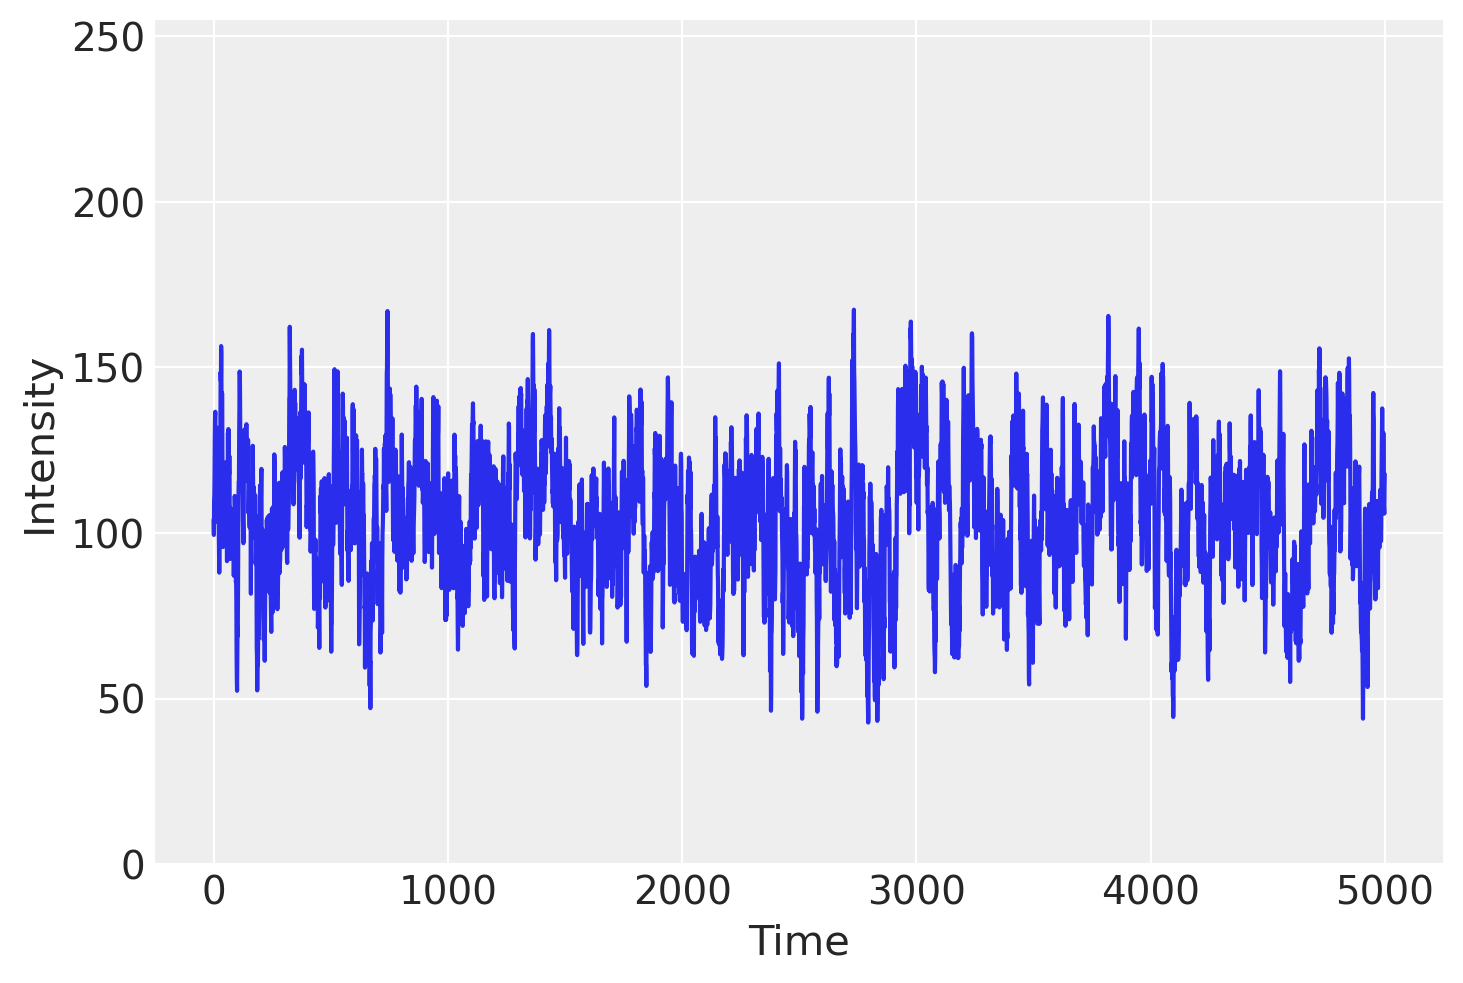

the mean of simulated data is 104.51500906936293
the std of simulated data is 20.263296492978967


In [4]:
simulated_data_single, simulated_t_single=simulate_single_decay_data(number_of_points,tau, quantization, intensity_mean, intensity_std, camera_noise,camera_std)

## Infer decay time from data using the AR(1) model in pymc3

## Statistical model

To fit our model AR1 model, we want to extract the following parameters: decay time, which is the $\tau$ above; stationary is the $\phi$, precision is defined as $\frac{1}{\sigma_e^2}$; center is the innovation mean. Our prior for $\tau$ is uniform from 0 to 50, based on the experimental data time scale; for precision, we also use a uniform prior from 0 to 10 times the calculated precision from simulation parameters; for center, it is uniform from the lowest possible intensity to the highest possible intensity.

Thus, the statistical model we use is:
$$ \tau \sim \text{Uniform} (0,50) $$
$$ \text{precision} \sim \text{Uniform} (0, 1) $$
$$ \mu \sim \text{Uniform} (I_{min}, I_{max}) $$
$$ p(X) \sim \text{AR1} (\text{k} = e^{-1/\tau}, \text{tau_e} = \text{precision}, \text{observed} = X-\mu )$$

In [5]:
quantization = 255

### Infer Simulated data

In [6]:
ar1_model_simulated=set_model(simulated_data_single,quantization,aged_time='simulated')
trace_single_model_simulated = run_model(ar1_model_simulated)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 17,951
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, precision, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.6985177821988182, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6860927884100303, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7192380643592237, but should be close to 0.8. Try to increase the number of tuning steps.


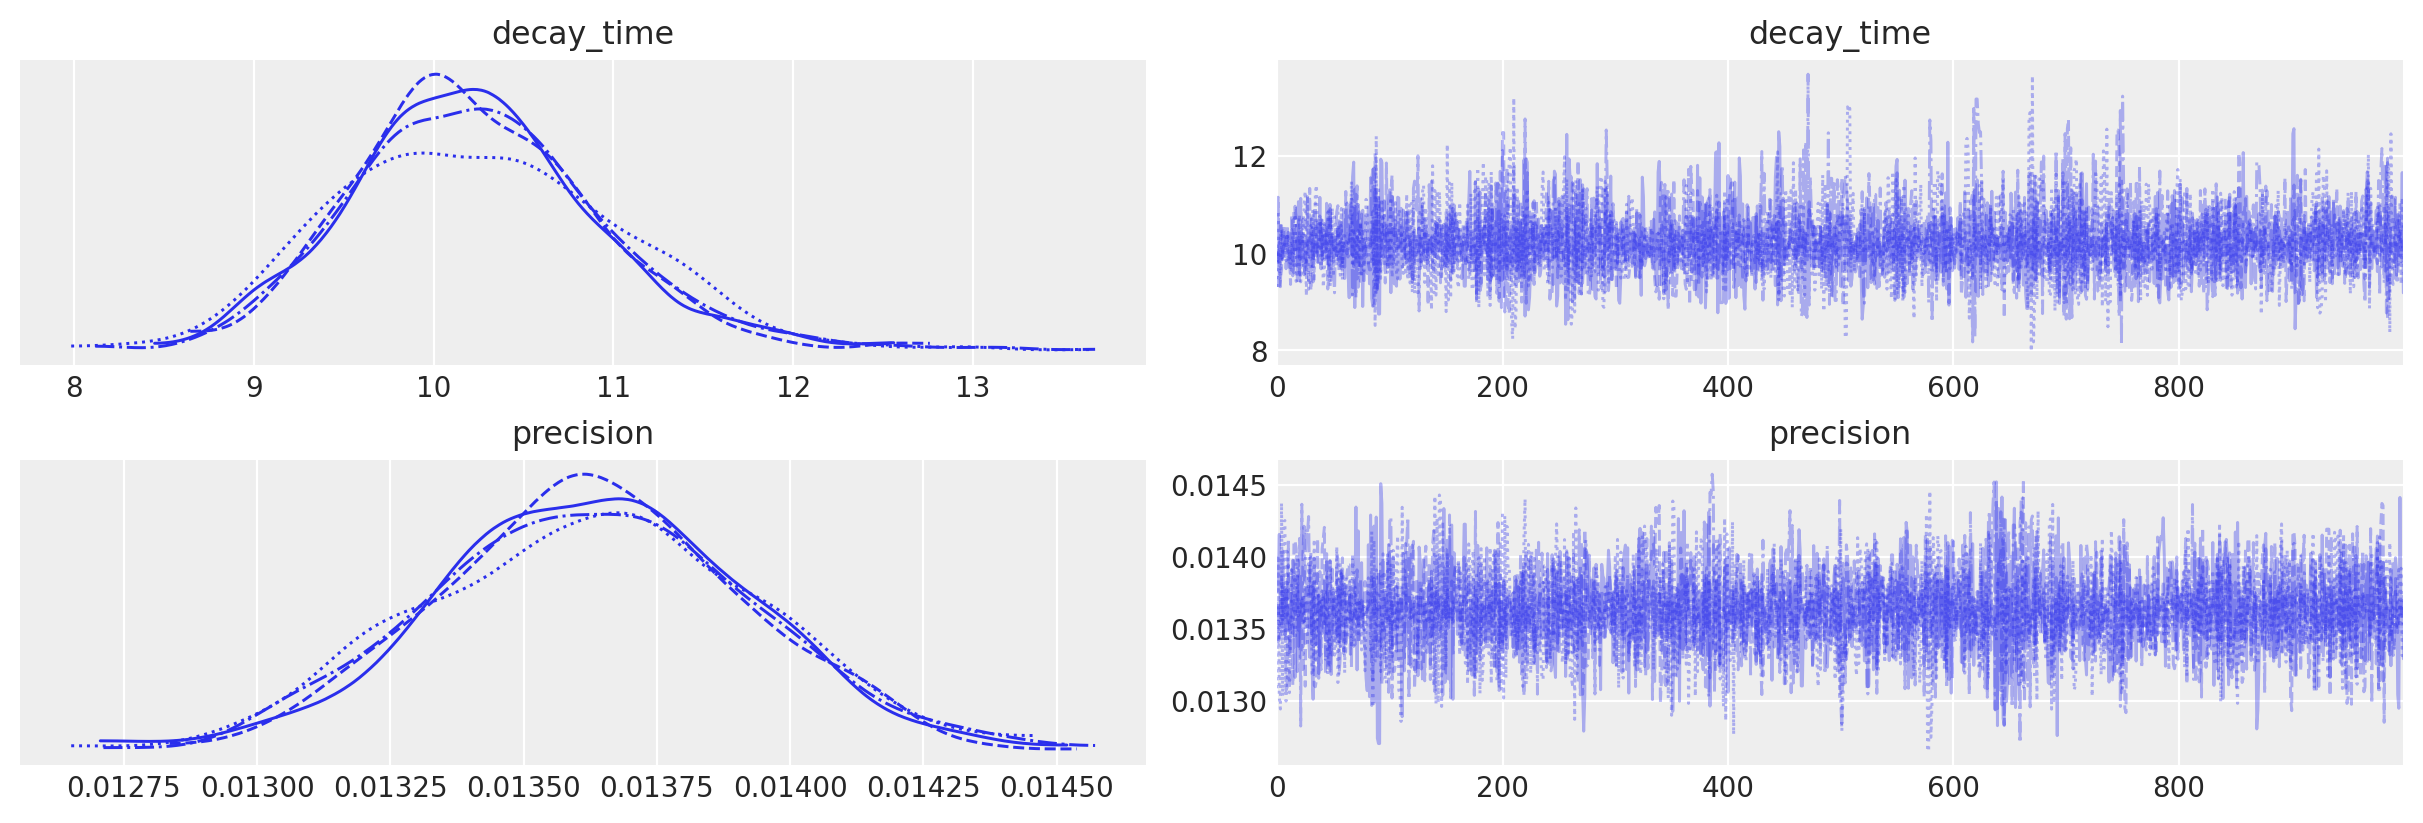

In [7]:
plot_trace(trace_single_model_simulated)

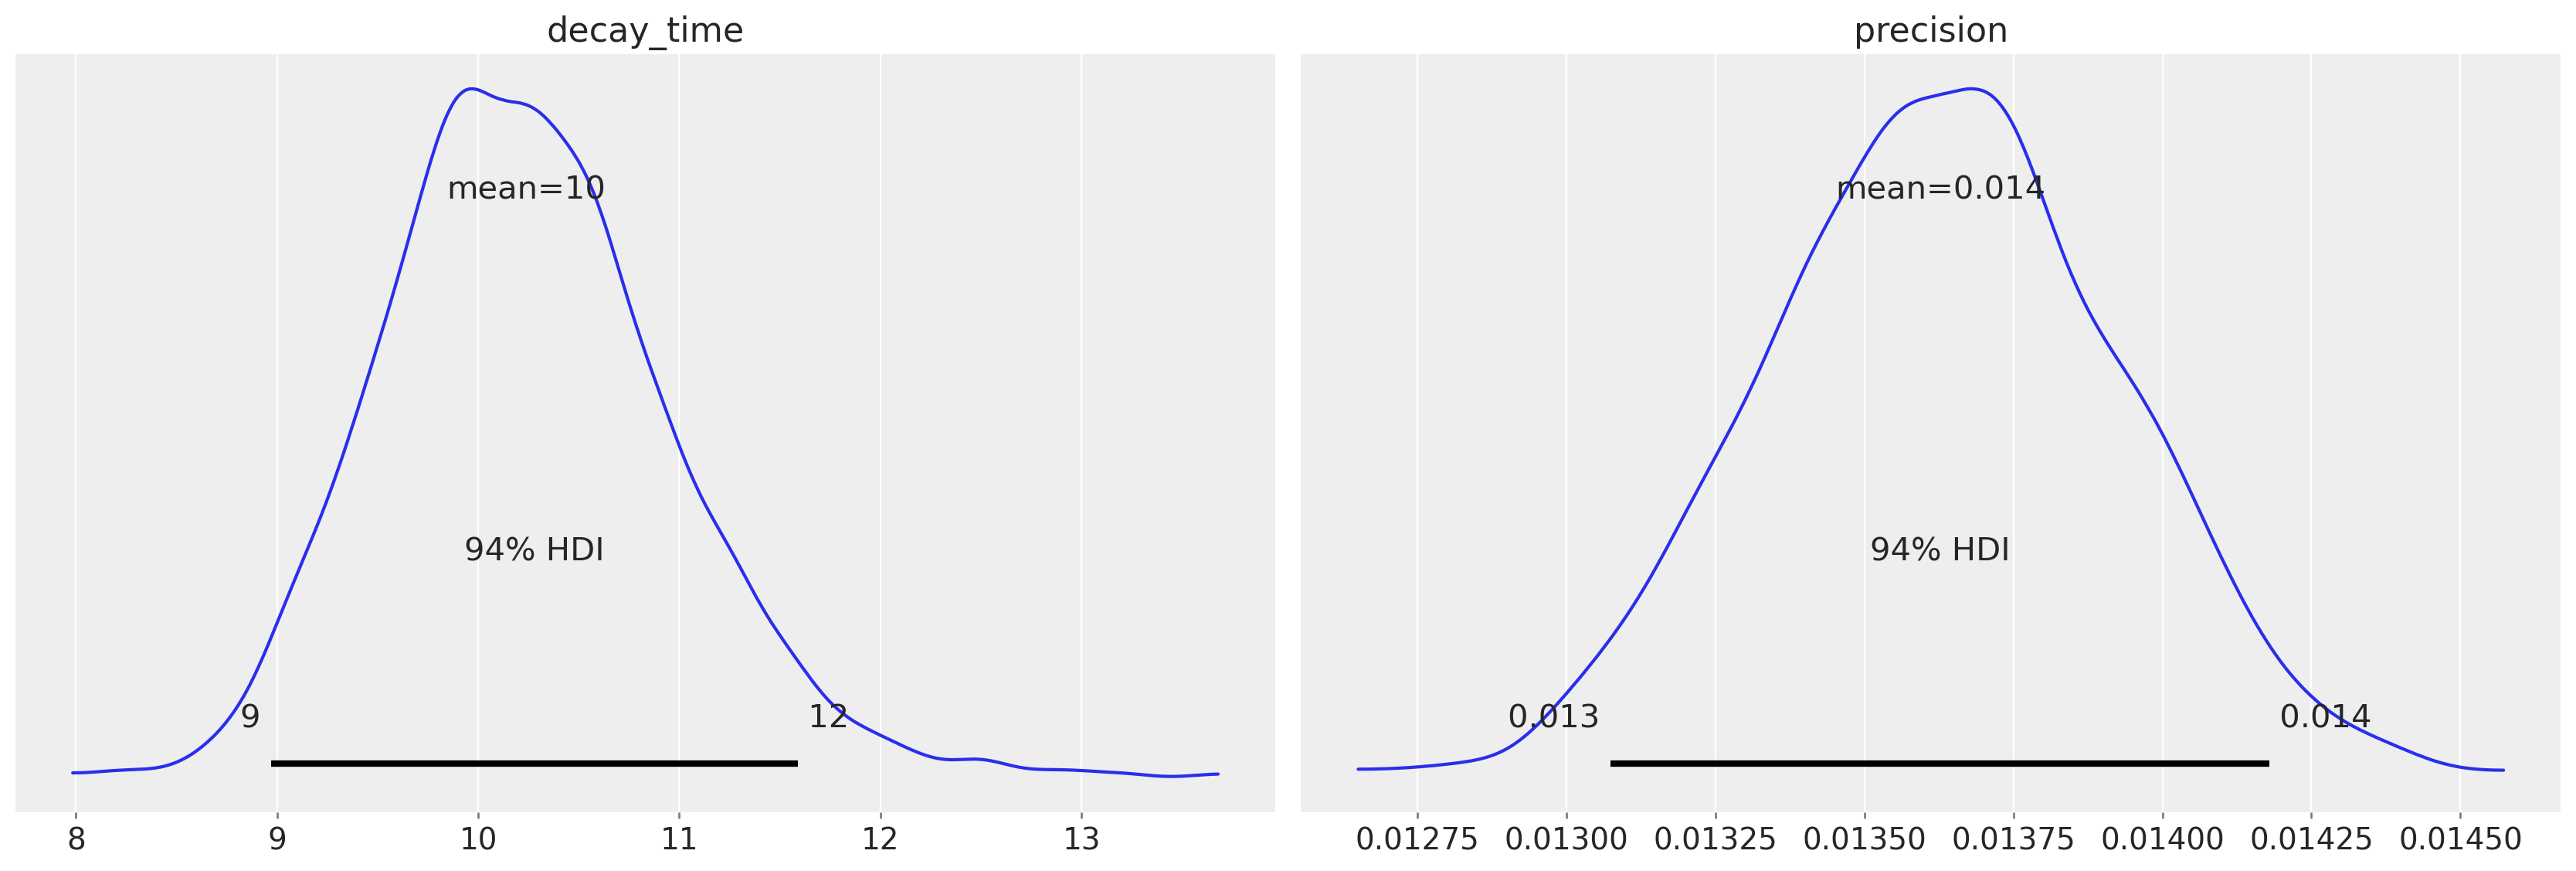

In [8]:
plot_posterior(trace_single_model_simulated)

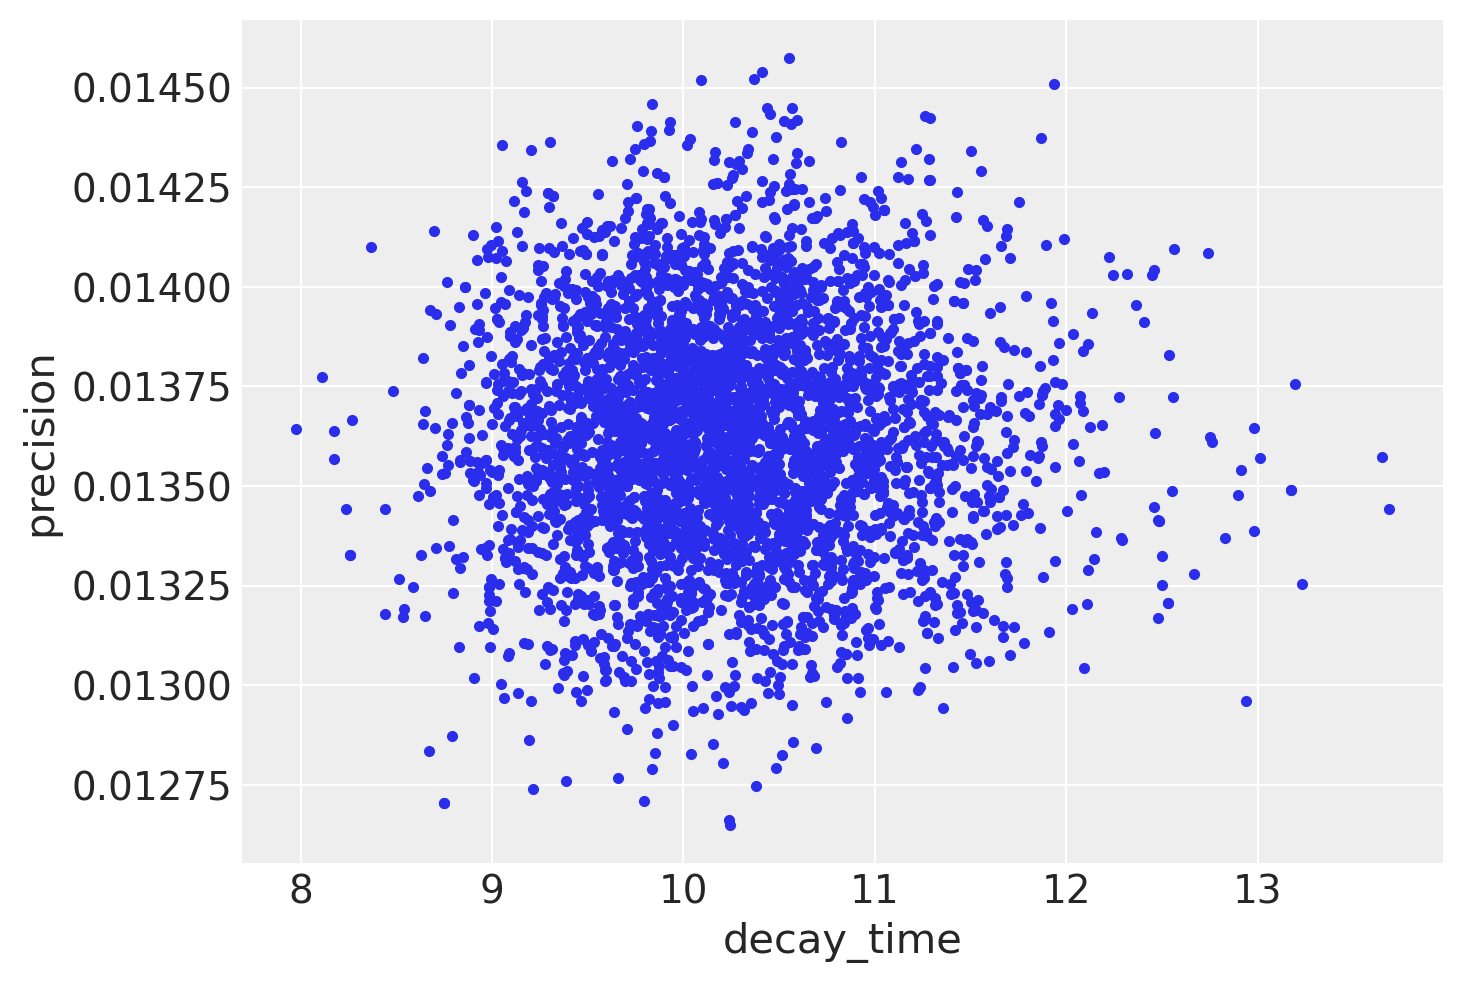

In [10]:
plot_pair(trace_single_model_simulated)

### Infer 2 hour aged sample

For choosing the data point, we pick a random point in the condensate sample, gaussian smooth the intensity at each time point with a 5*5 kernel to reduce the effect from camera noise.

/Users/wenyun/Documents/GitHub/Condensate_speckles/condensate_speckle/example_data/[100, 100]_2h_intensity.csv


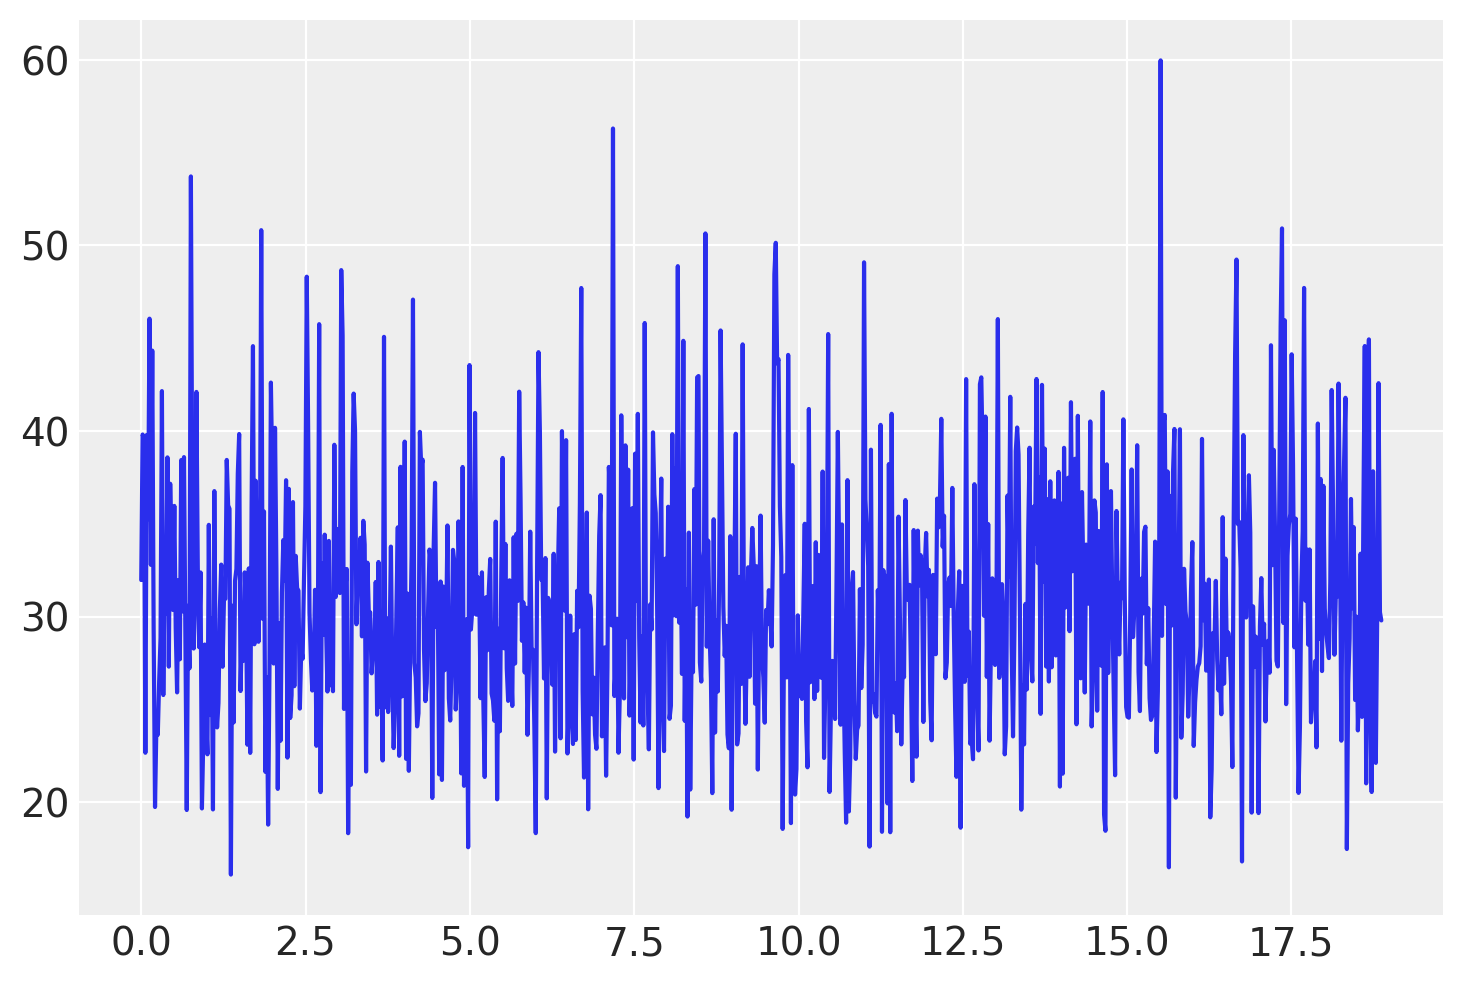

In [10]:
#Load in real data and plot
data_2h = load_data('[100, 100]_2h_intensity.csv',data_dir='condensate_speckle/example_data')

In [12]:
# Sample with pymc3 using the single timescale model
ar1_model_2h=set_model(data_2h['Intensity'],quantization,'2h')
trace_single_model_2h = run_model(ar1_model_2h)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 91600
Interrupted at 91,599 [45%]: Average Loss = 4,850.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, precision, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


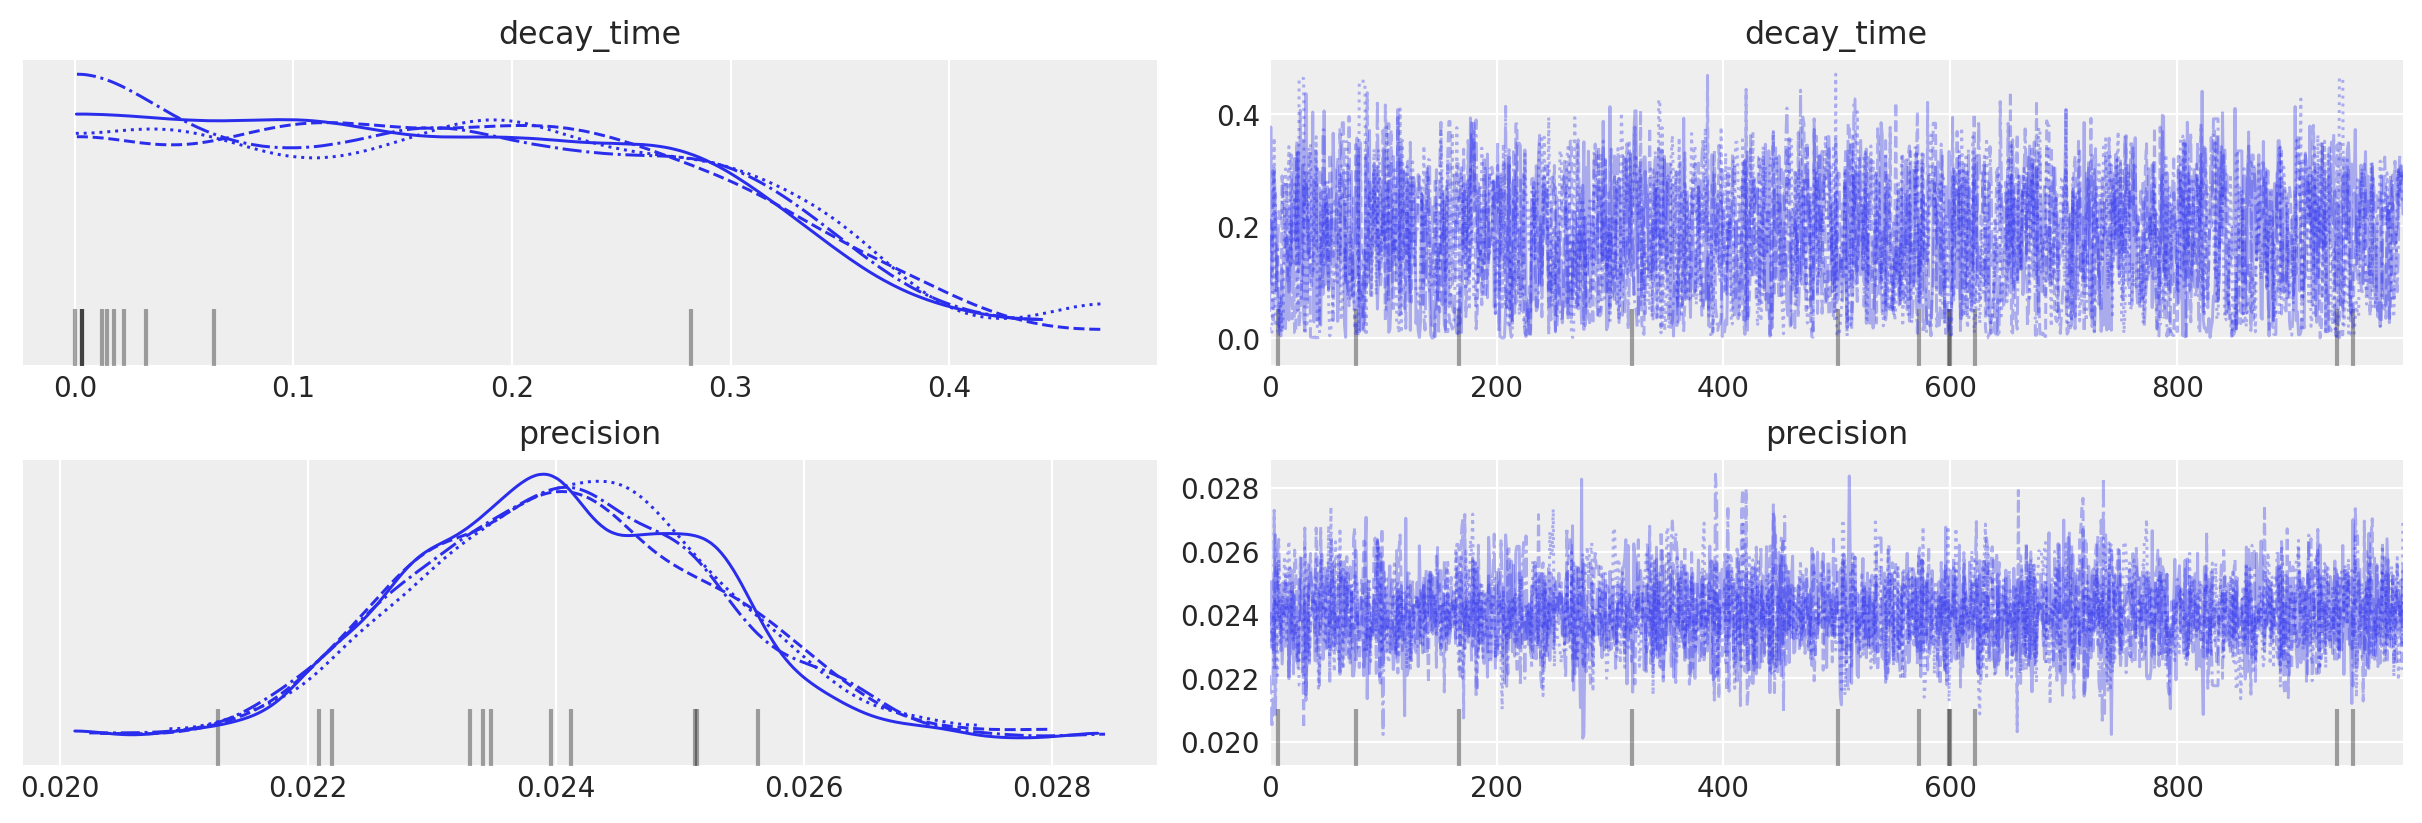

In [13]:
plot_trace(trace_single_model_2h)

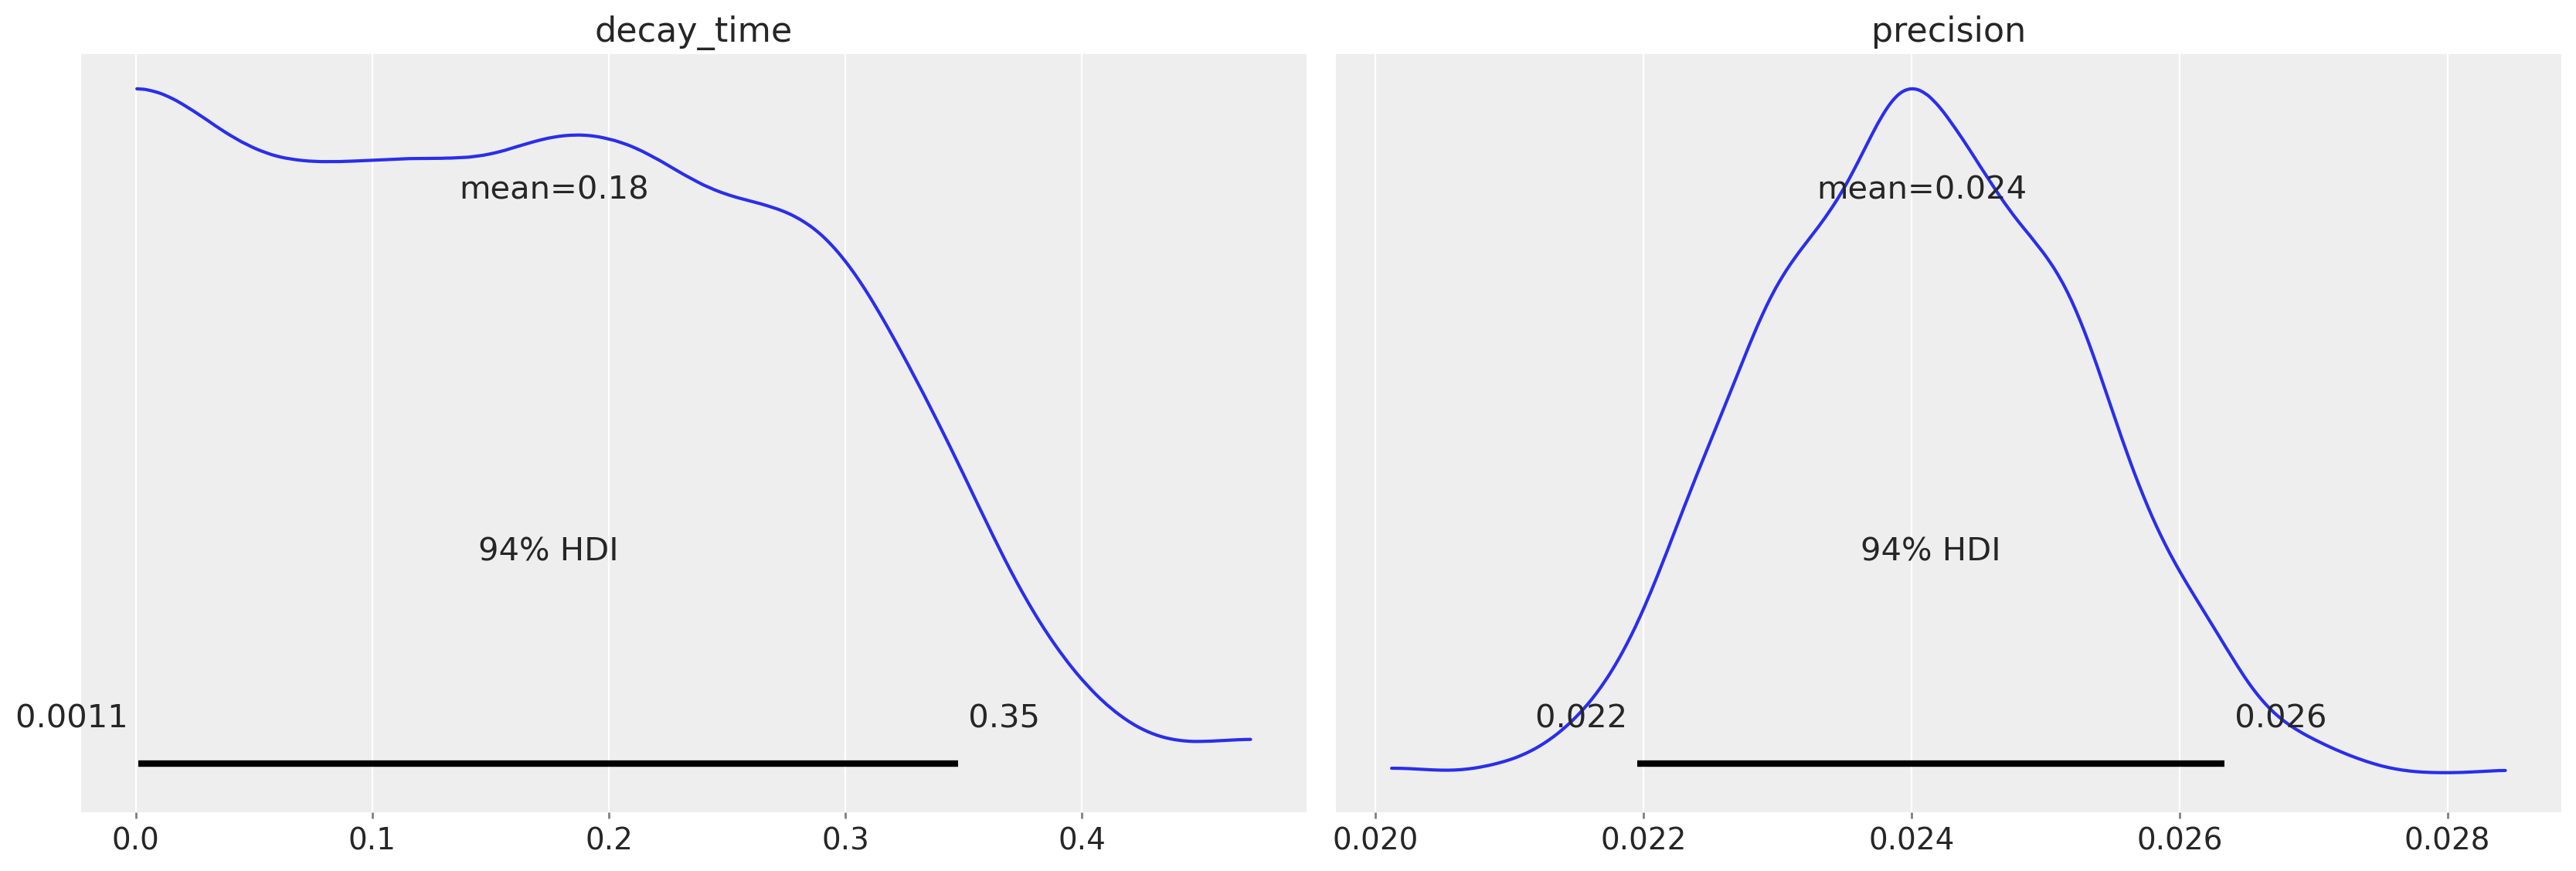

In [14]:
plot_posterior(trace_single_model_2h)

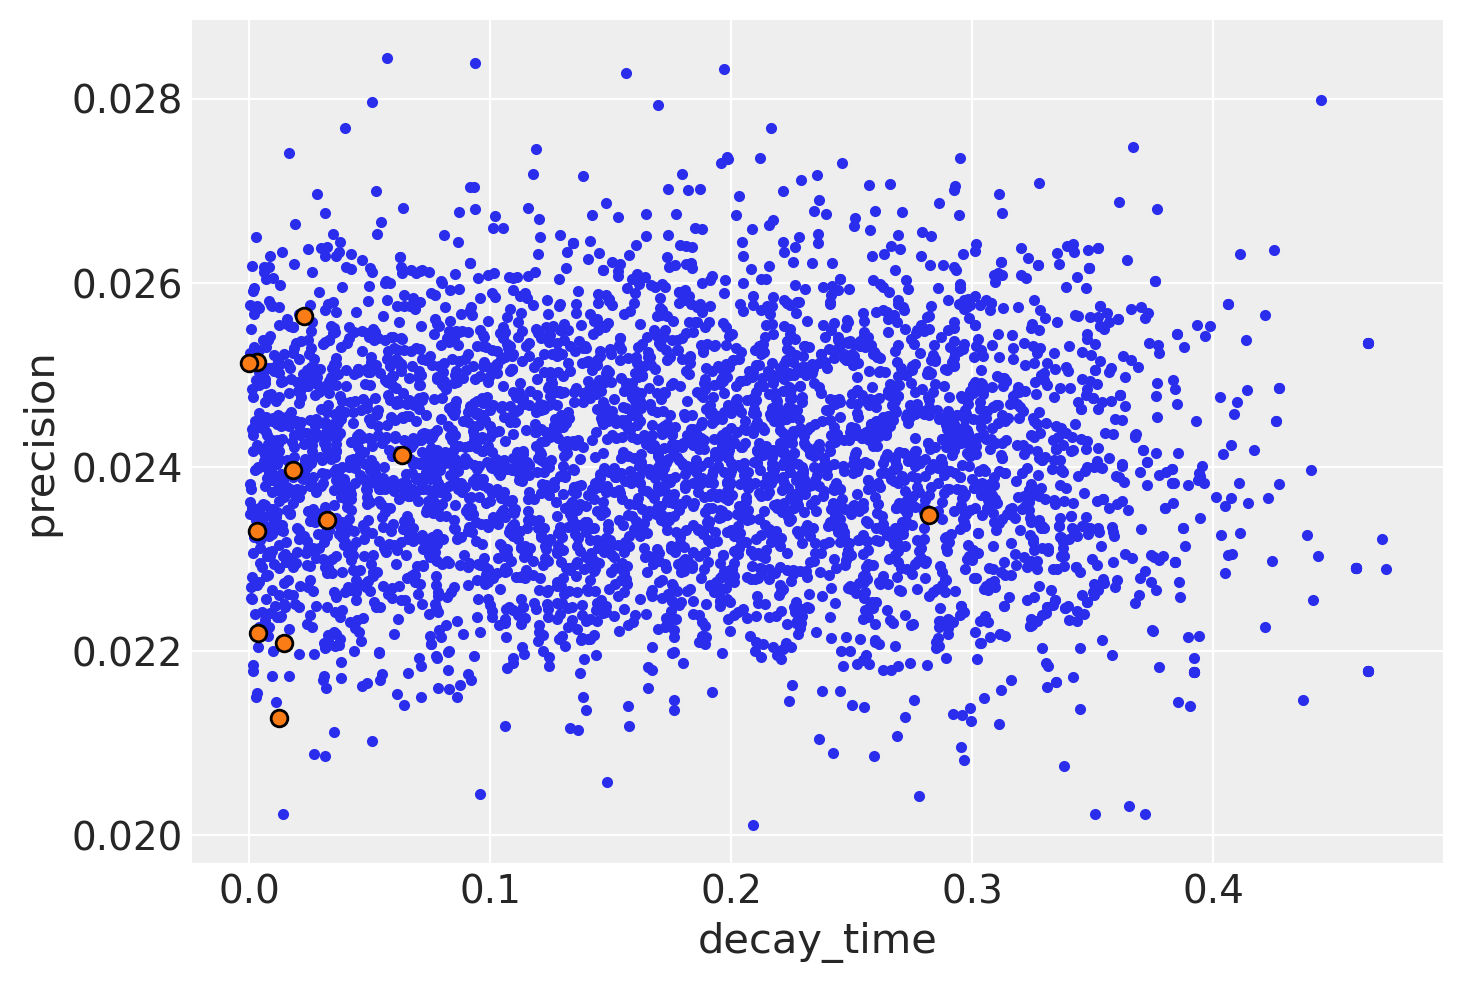

In [15]:
plot_pair(trace_single_model_2h)

### Infer 7 hour aged sample

/Users/wenyun/Documents/GitHub/Condensate_speckles/condensate_speckle/example_data/[100, 117]_7h_intensity.csv


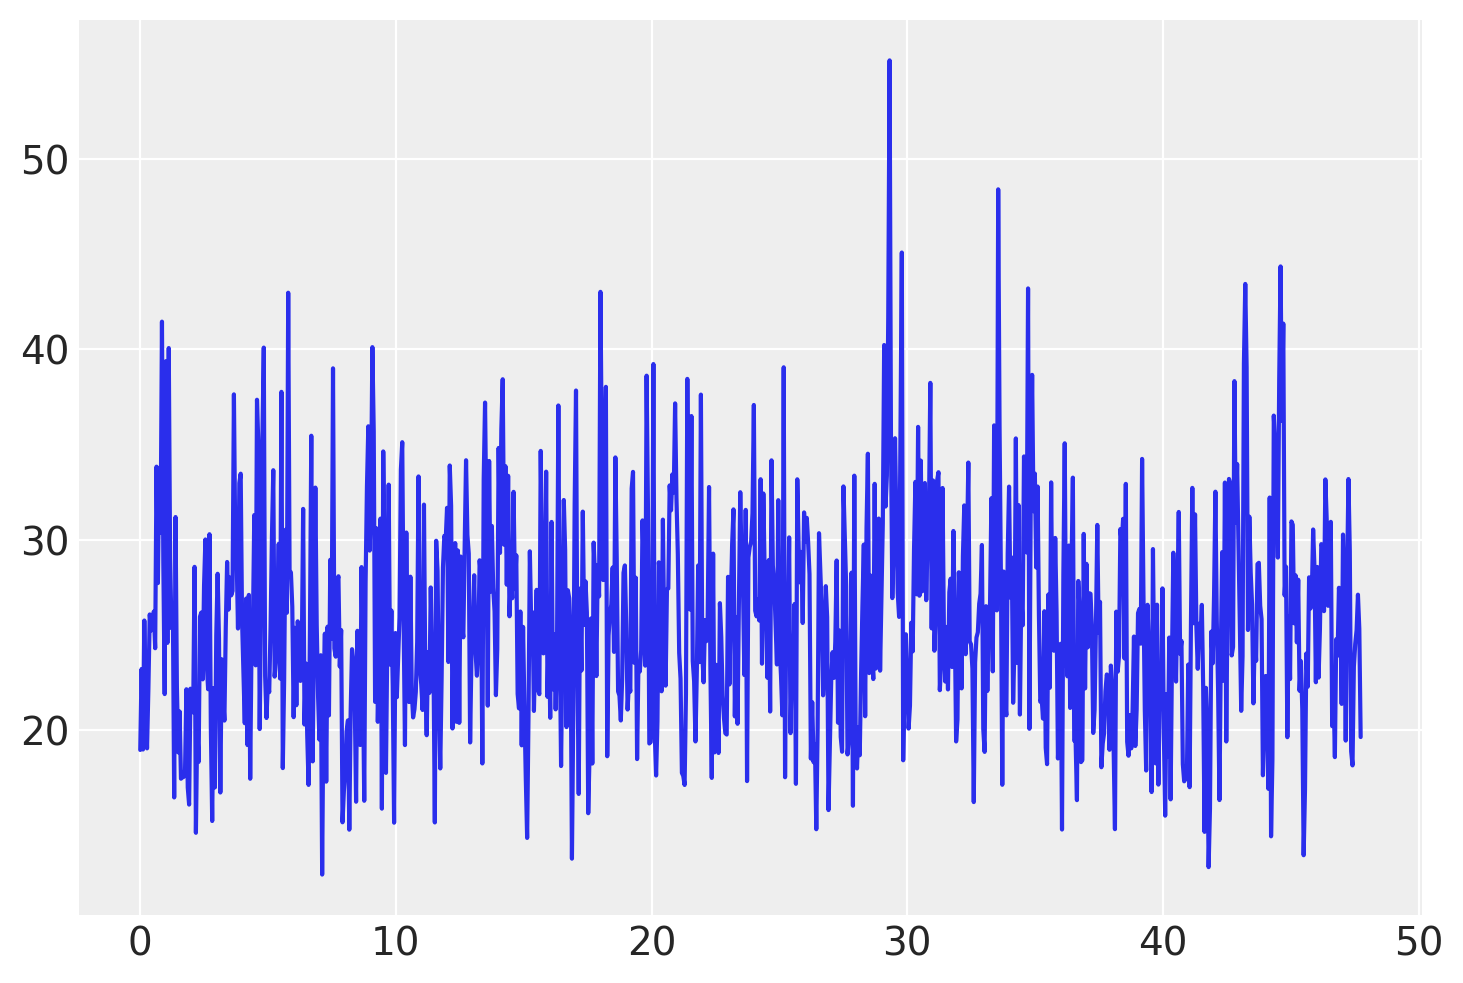

In [11]:
data_7h = load_data('[100, 117]_7h_intensity.csv',data_dir='condensate_speckle/example_data')

In [17]:
ar1_model_7h=set_model(data_7h['Intensity'],quantization)
trace_single_model_7h= run_model(ar1_model_7h)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 96600
Interrupted at 96,599 [48%]: Average Loss = 4,463.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, precision, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


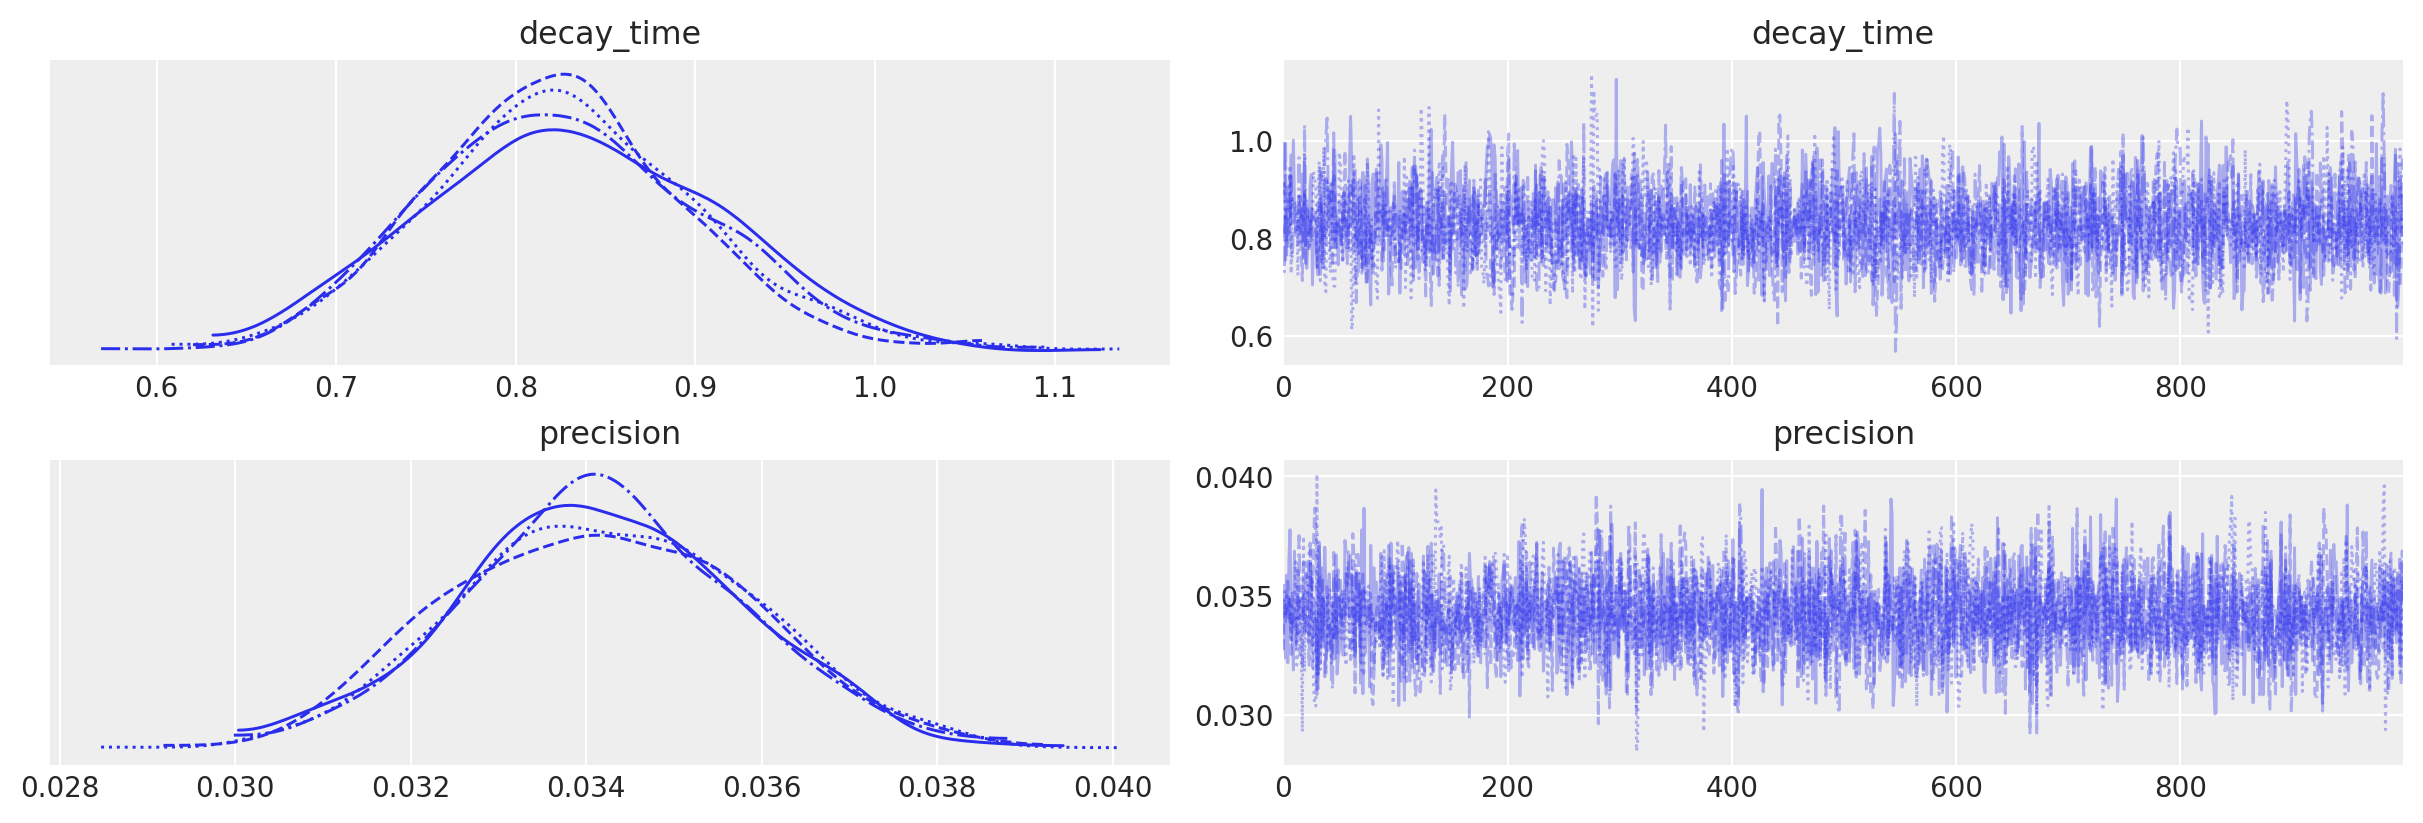

In [18]:
plot_trace(trace_single_model_7h)

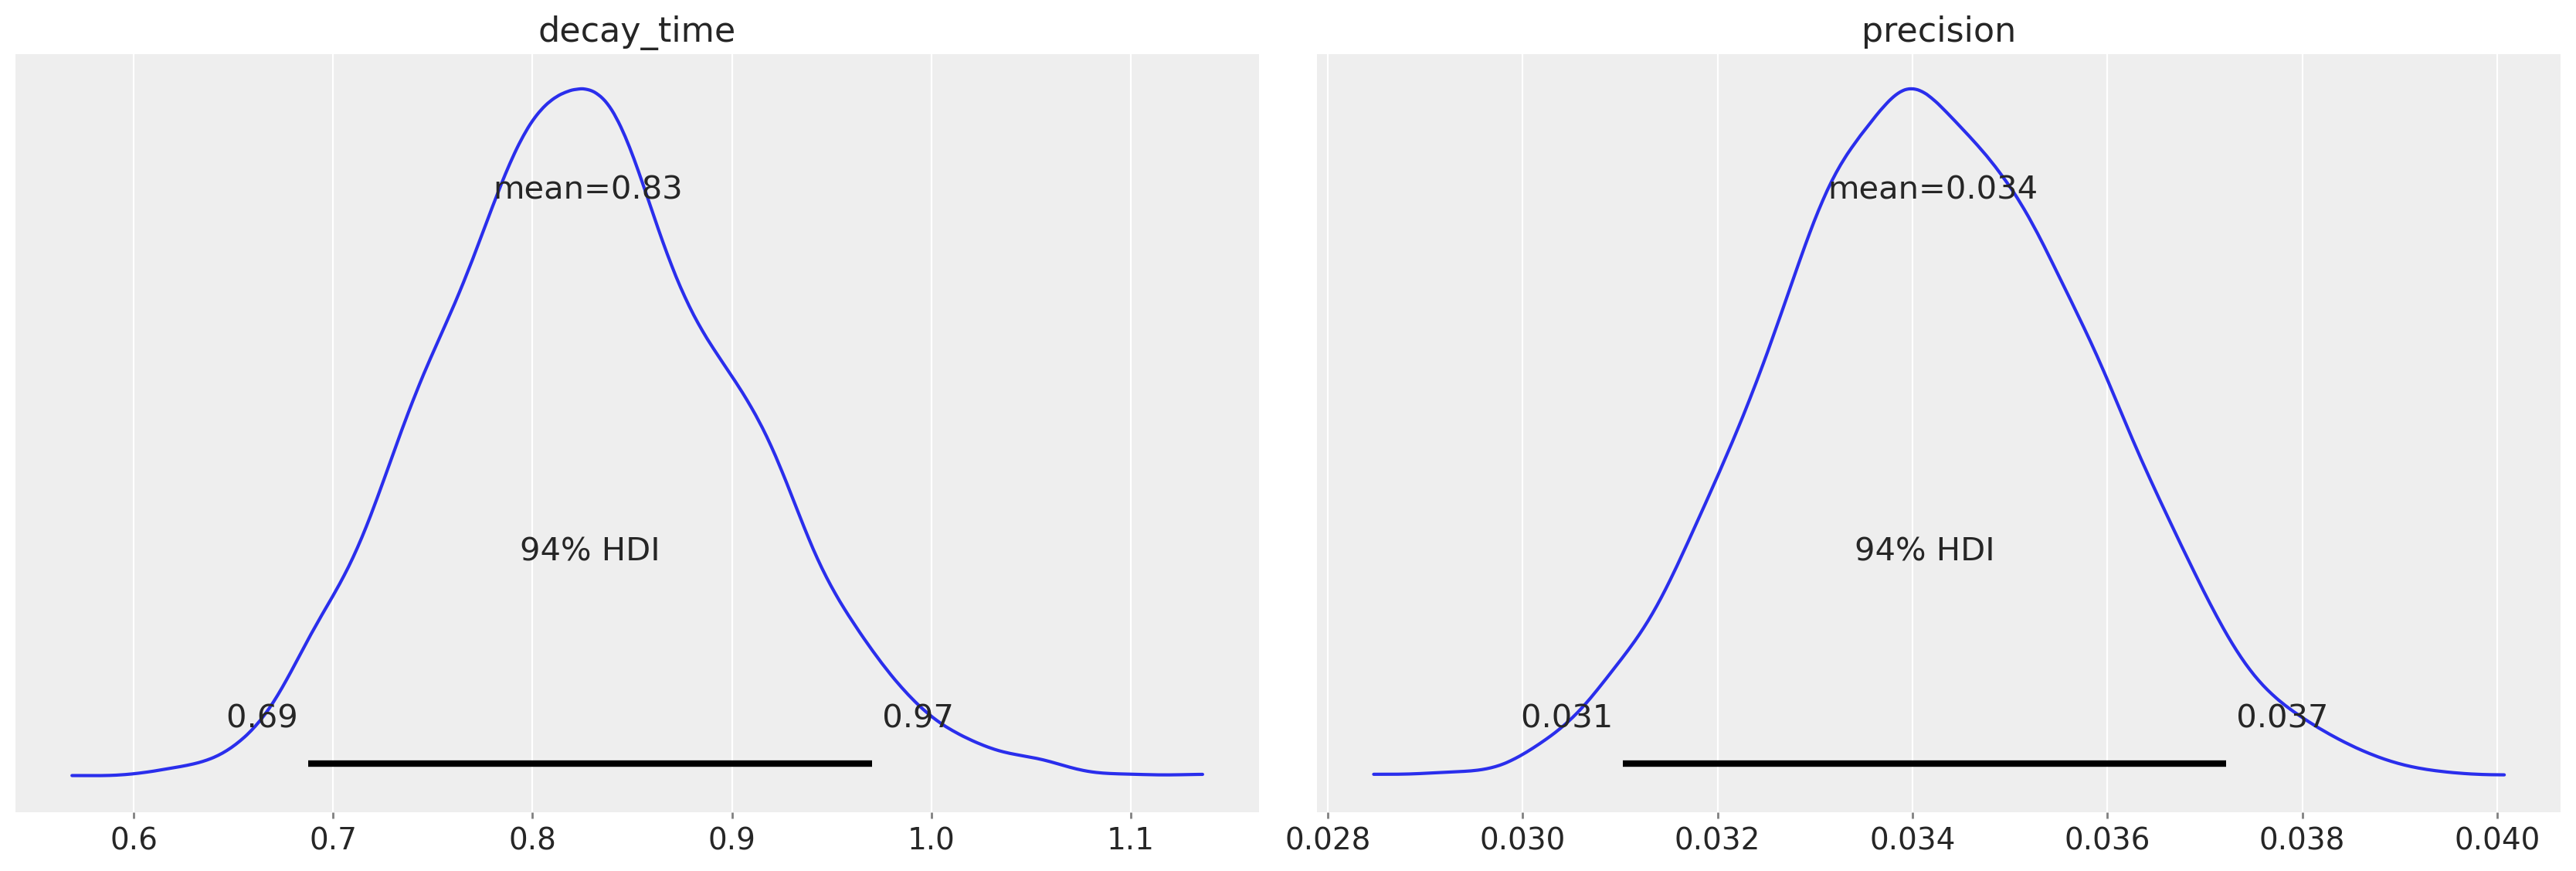

In [19]:
plot_posterior(trace_single_model_7h)

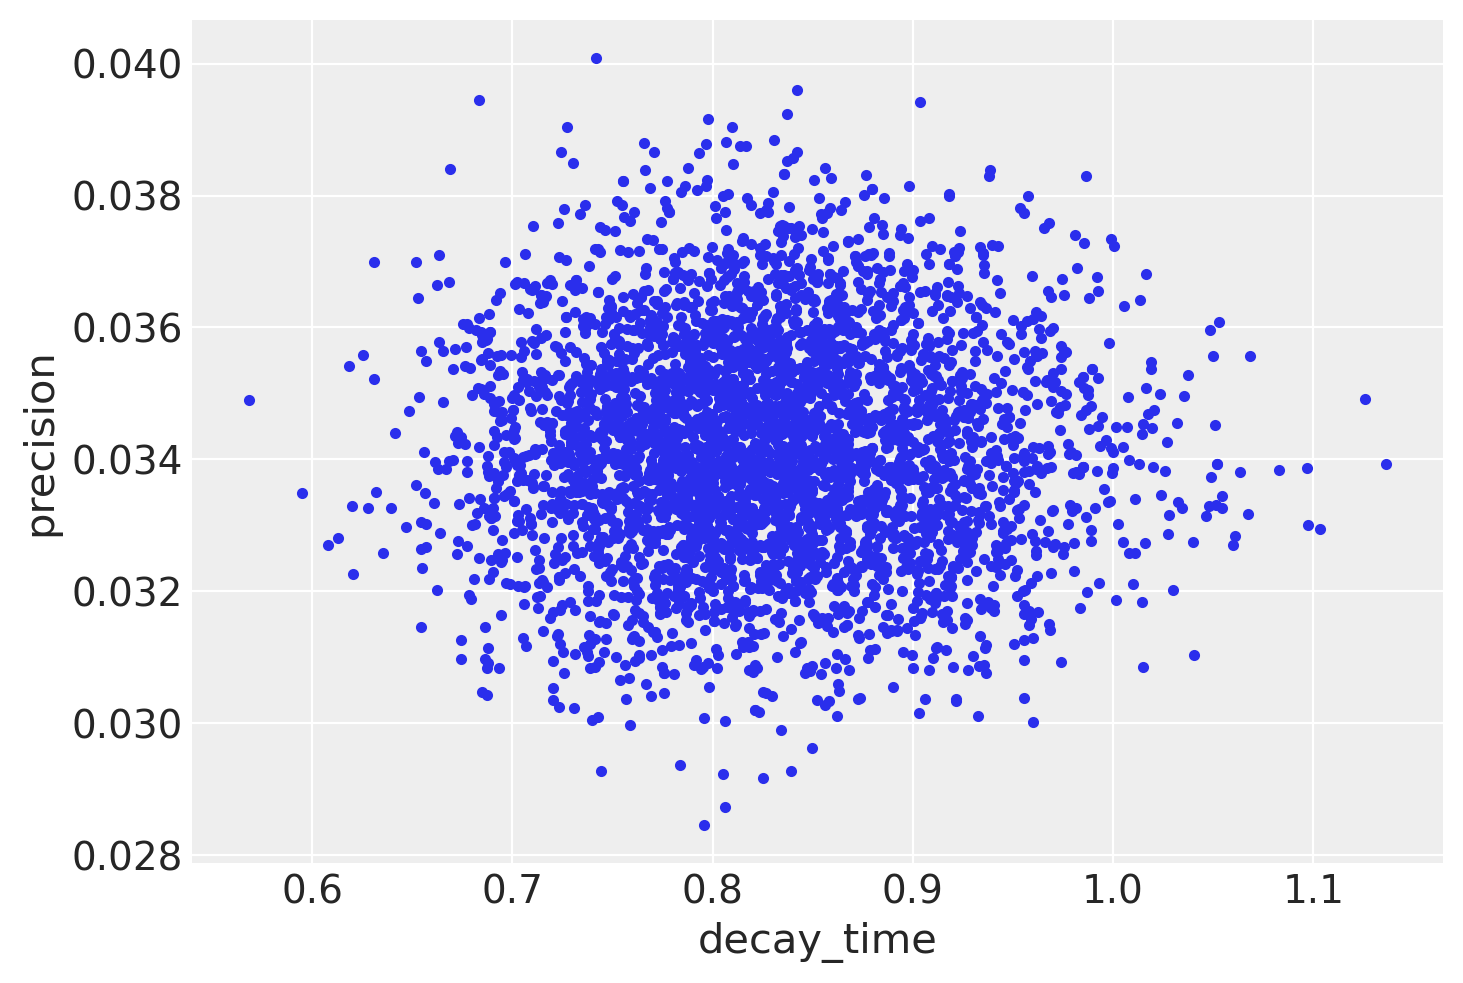

In [20]:
plot_pair(trace_single_model_7h)

### Infer 24 hour aged sample

/Users/wenyun/Documents/GitHub/Condensate_speckles/condensate_speckle/example_data/[120, 145]_intensity.csv


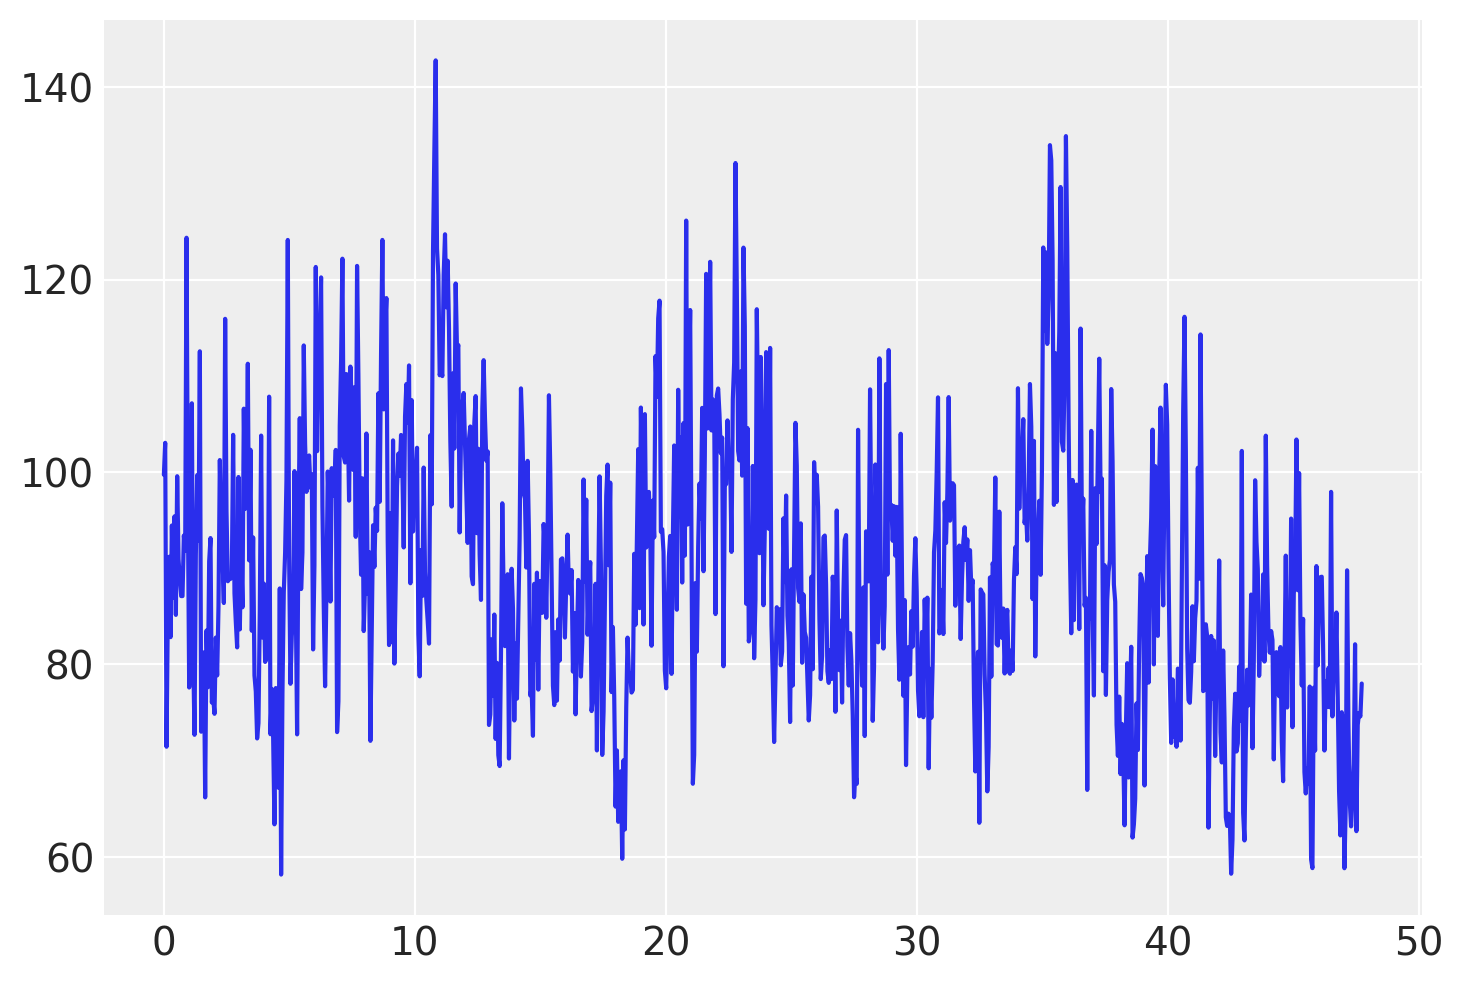

In [12]:
data_24h = load_data('[120, 145]_intensity.csv',data_dir='condensate_speckle/example_data')

In [22]:
ar1_model_24h=set_model(data_24h['Intensity'],quantization)
trace_single_model_24h= run_model(ar1_model_24h)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 169900
Interrupted at 169,899 [84%]: Average Loss = 6,897.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, precision, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.


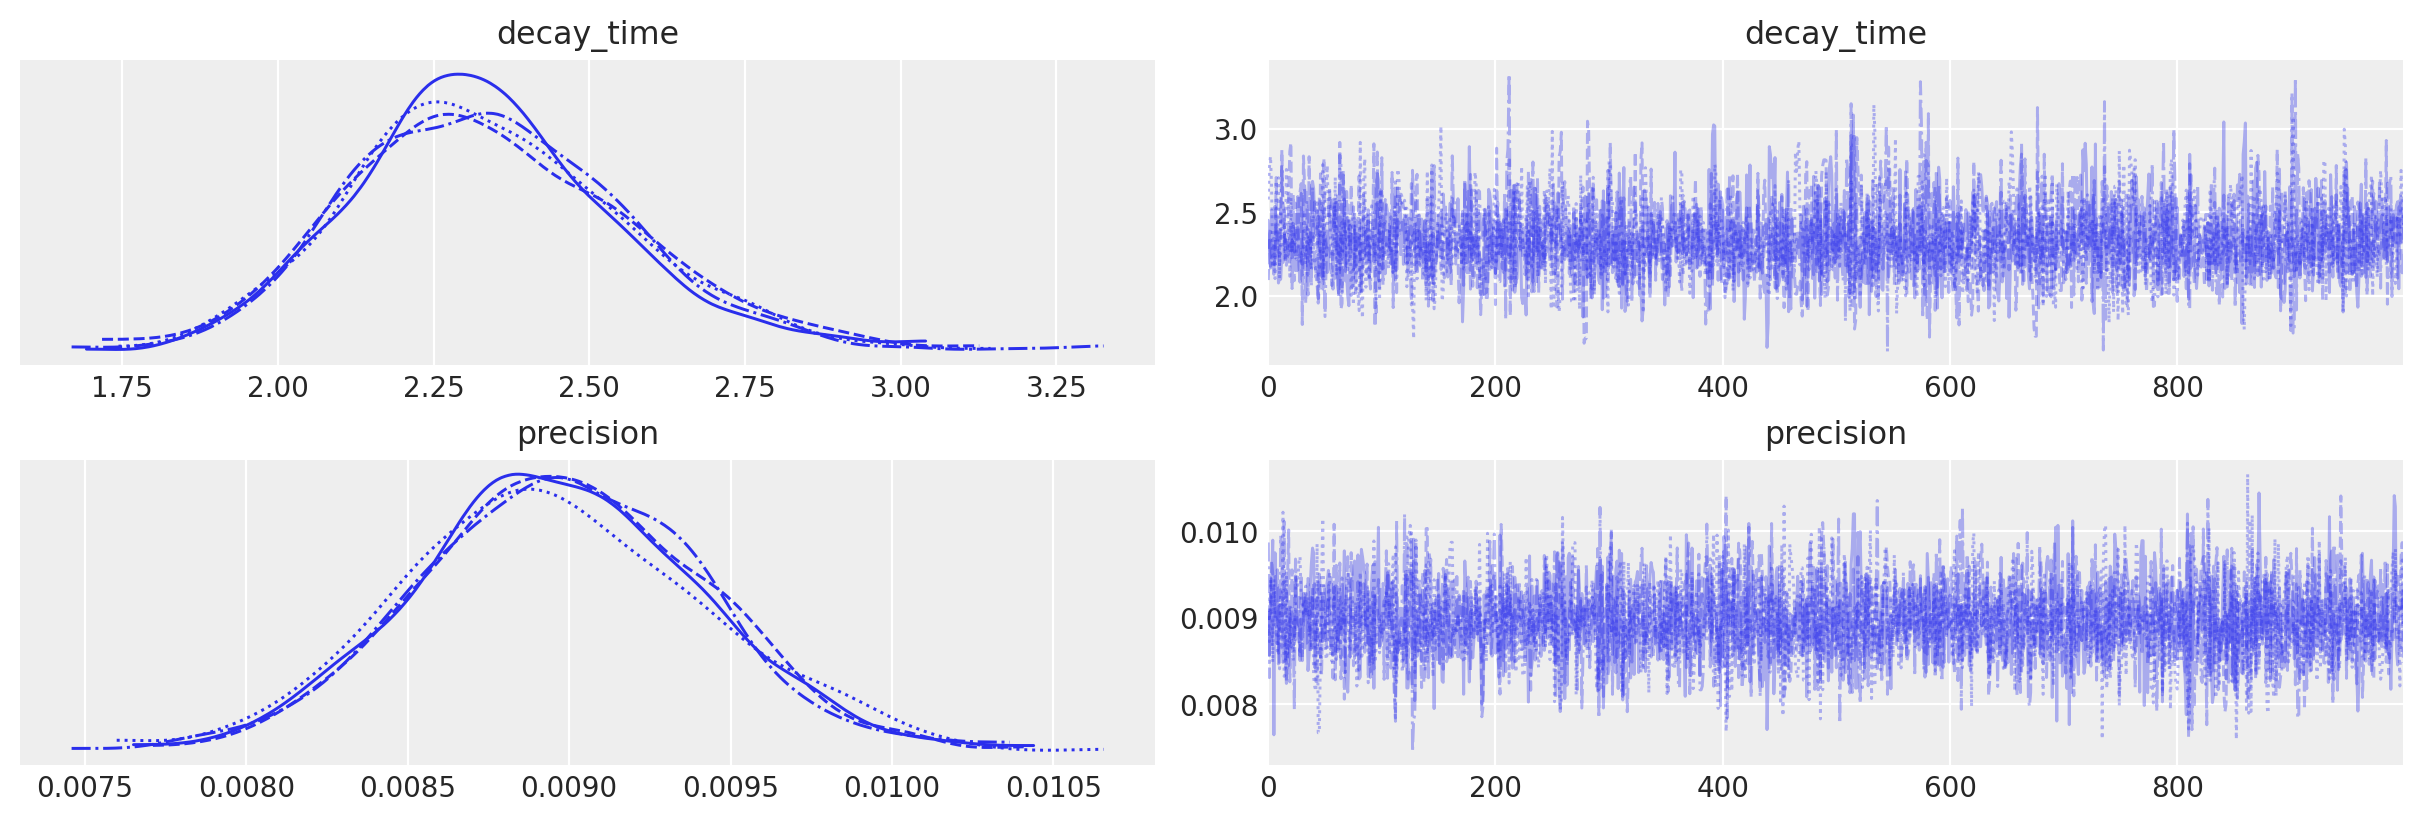

In [23]:
plot_trace(trace_single_model_24h)

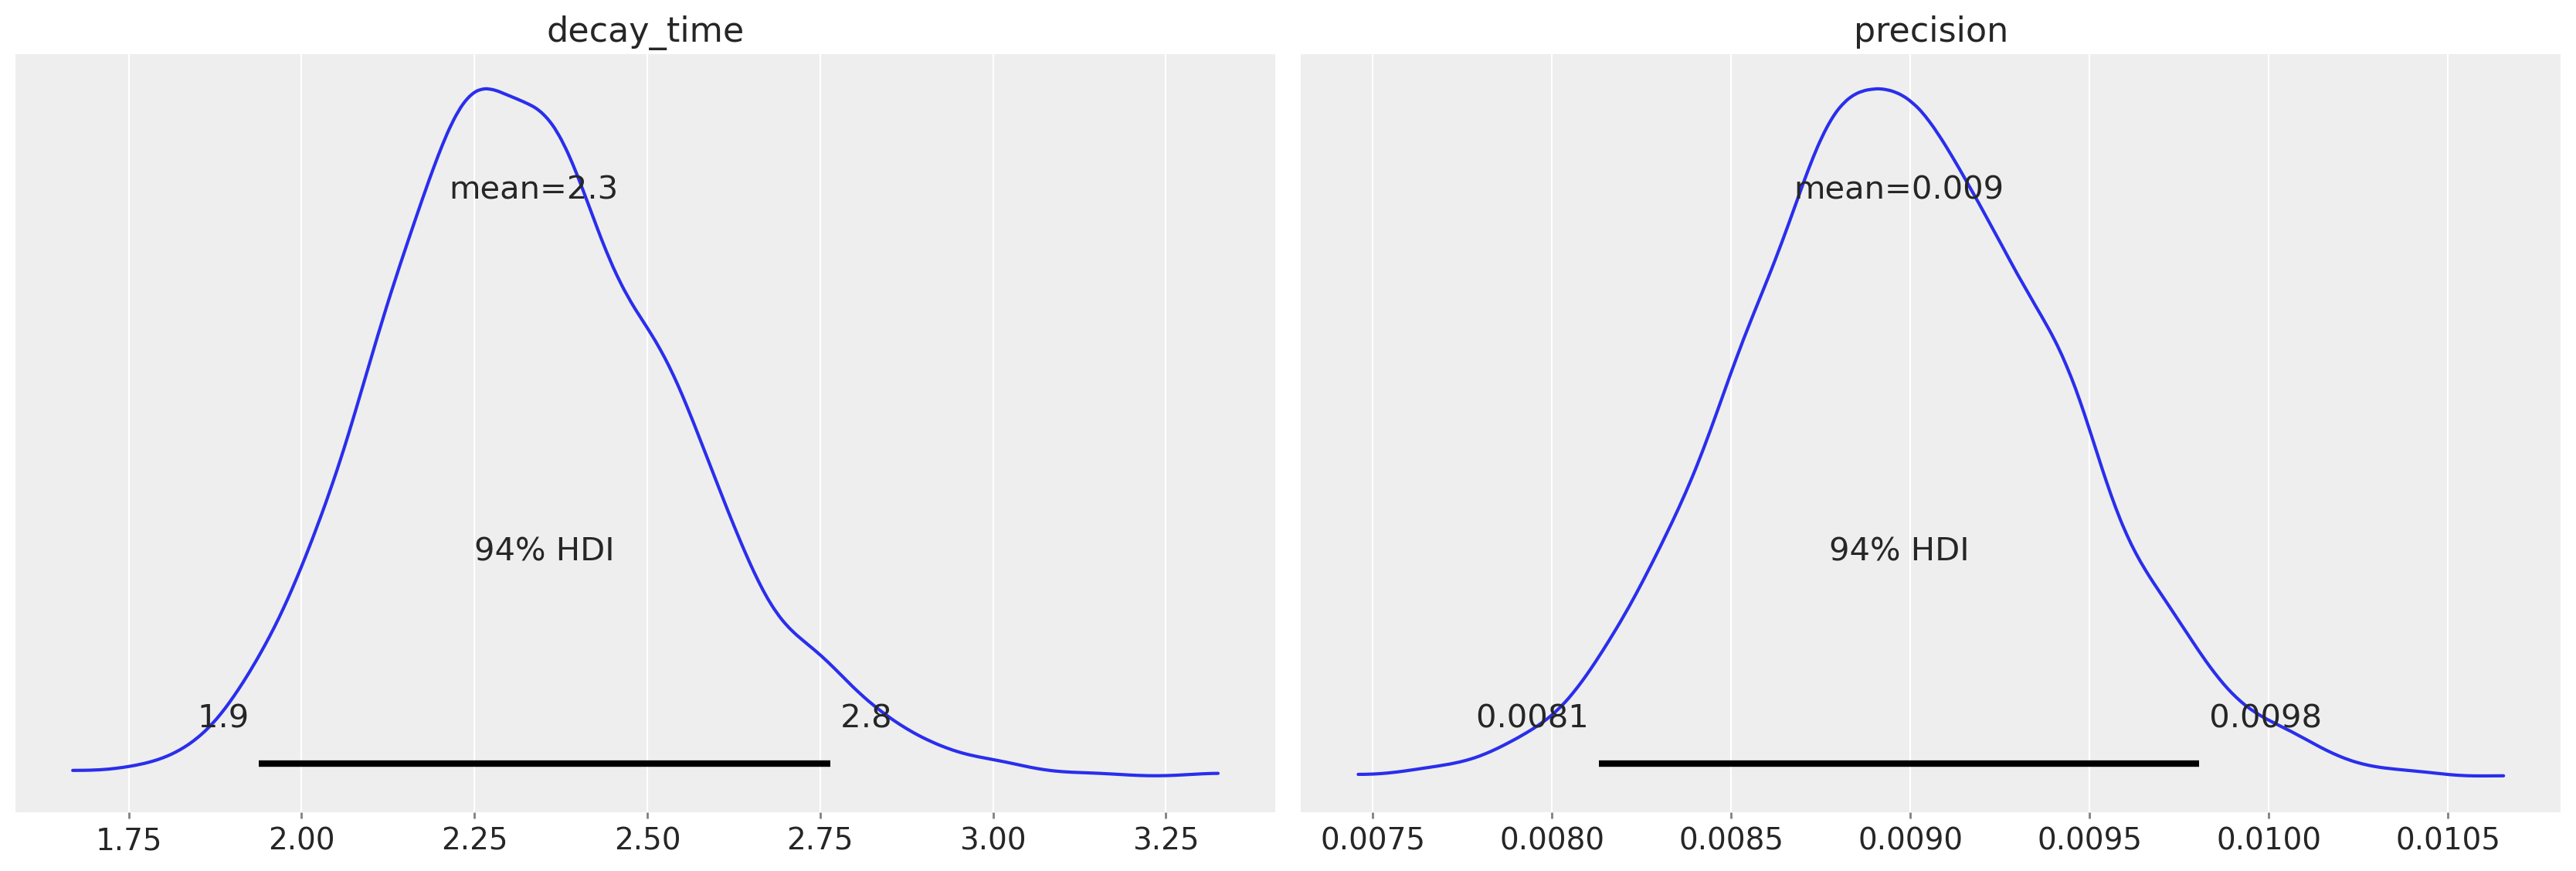

In [24]:
plot_posterior(trace_single_model_24h)

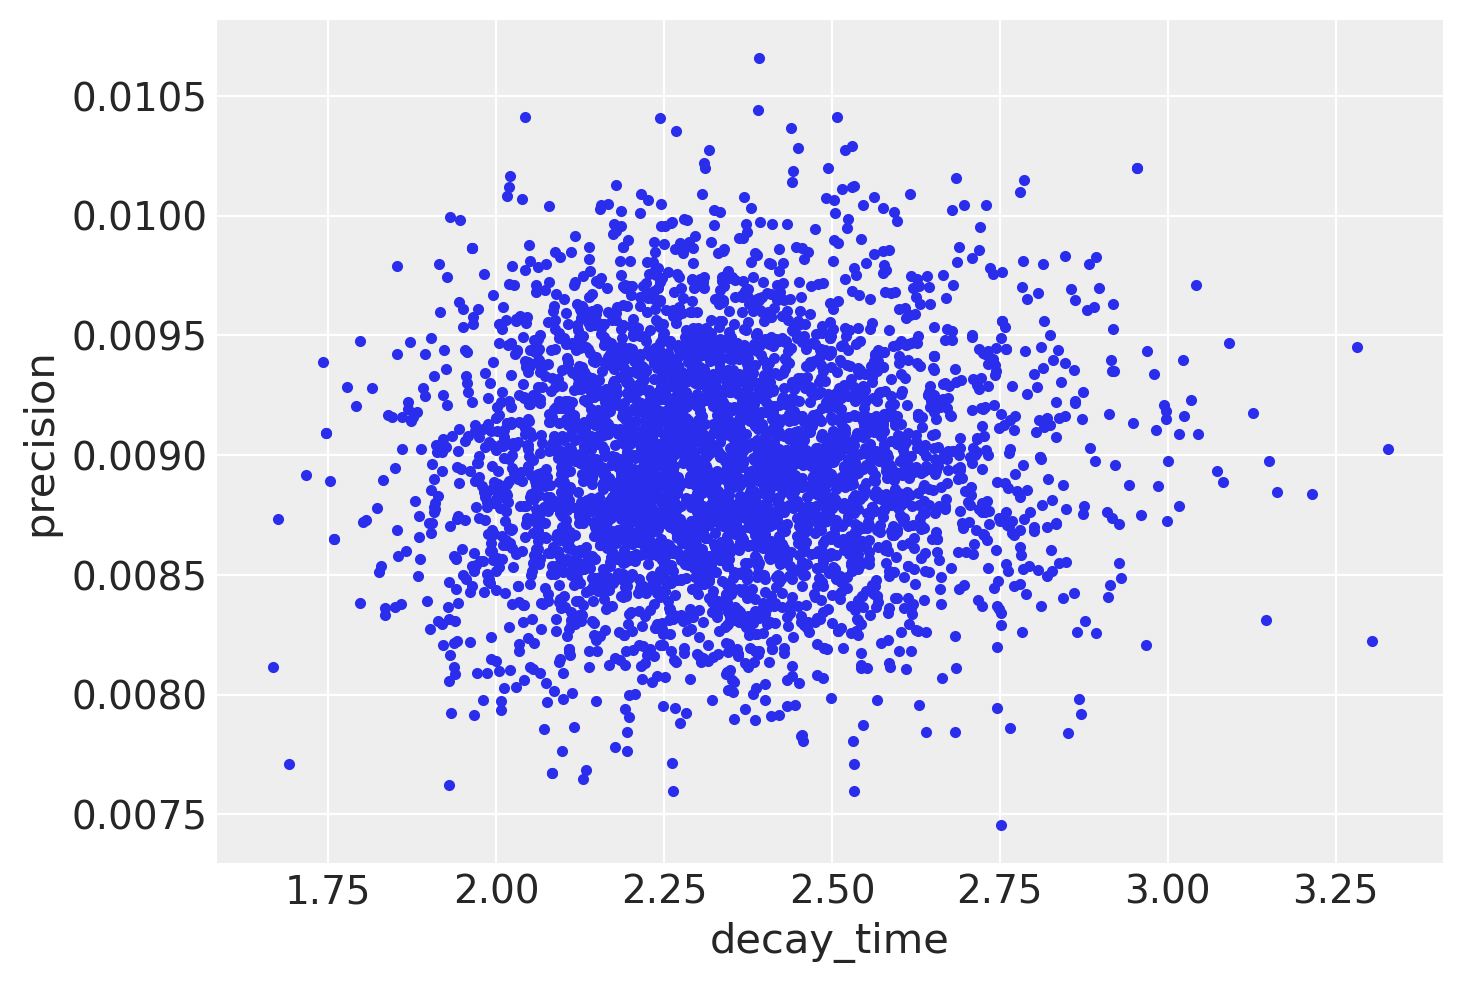

In [25]:
plot_pair(trace_single_model_24h)

# "Can do" Goal - 2 timescale decay

## simulate data

In [3]:
number_of_points=1000
tau_1=10
tau_2=30
relative_var=0.5
quantization=255
intensity_mean=150
intensity_std=40
camera_noise=8
camera_std=3

precision 1 is 0.006895819457658737
precision 2 is 0.01938194393009559


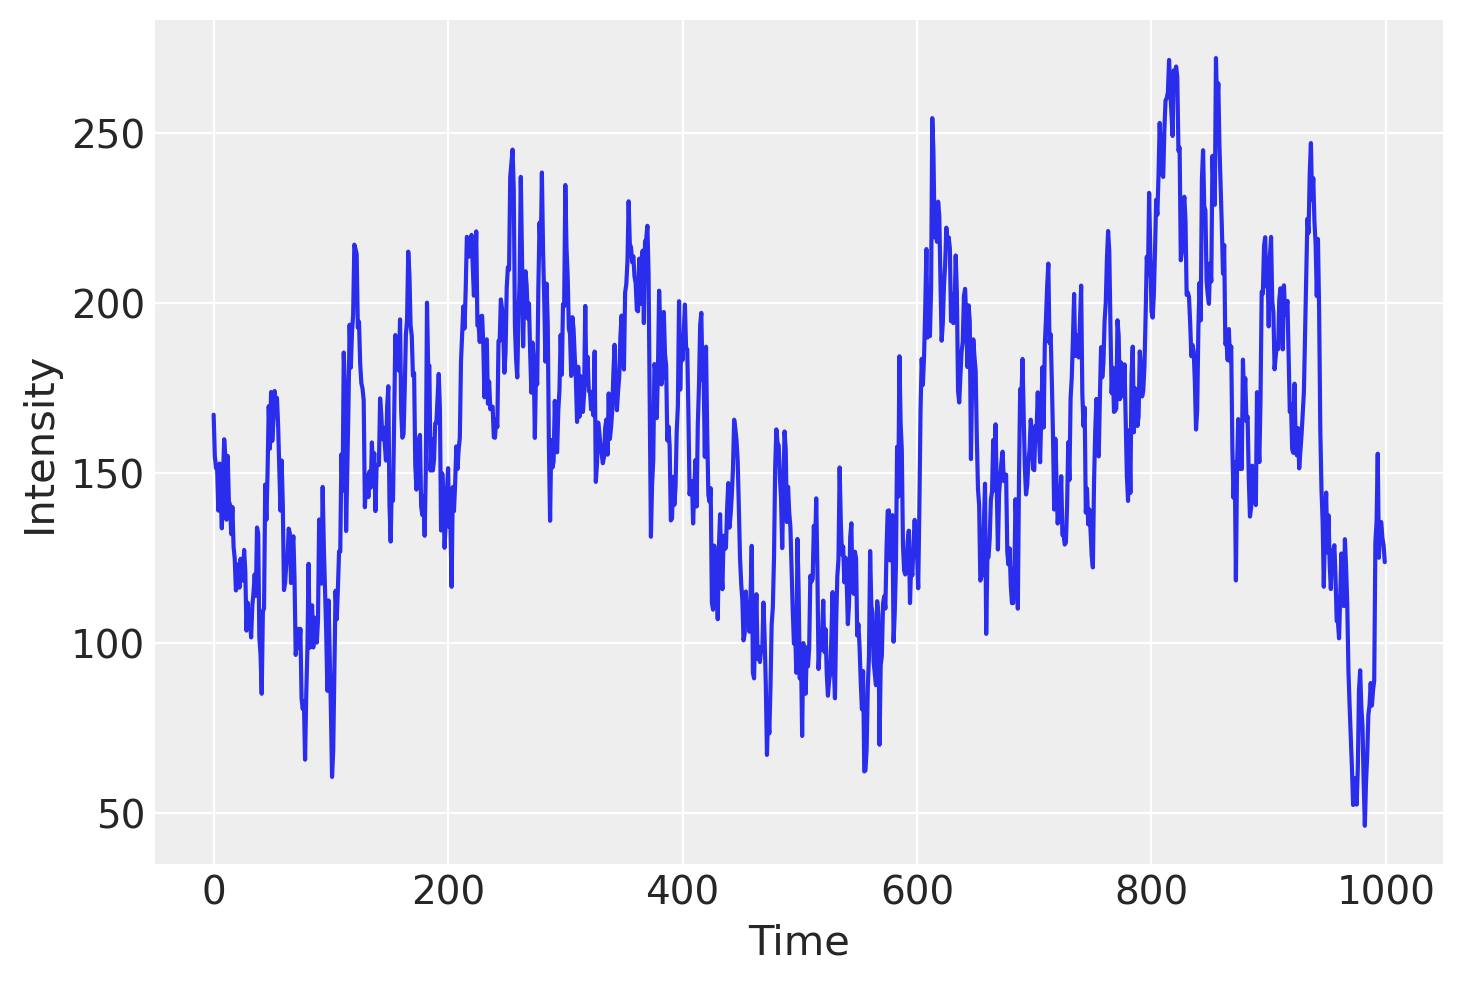

the mean of camera noise data is 8.05594367545003
the std of camera noise data is 2.897101240053561
the mean of fast simulated data is 2.6737264606507796
the mean of slow simulated data is -1.999622797742295
the mean of simulated data is 158.73004733835853
the std of simulated data is 42.363954850669565
the (variance/mean^2) of simulated data is 0.07123192835228932


In [4]:
simulated_data_double, simulated_t_double=simulate_double_decay_data(number_of_points,tau_1,tau_2, relative_var,quantization, intensity_mean, intensity_std, camera_noise, camera_std)

## Infer decay time from data using the AR(1)+AR(1) model in pymc3

### Infer simulated data

In [5]:
ar1_multi_model_double=set_single_precision_model(simulated_data_double, quantization,aged_time='simulated')
trace_multi_model_double = run_model(ar1_multi_model_double)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 4,943.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_2, y_1, precision, decay_time_split, decay_time_1]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 265 seconds.
The number of effective samples is smaller than 10% for some parameters.


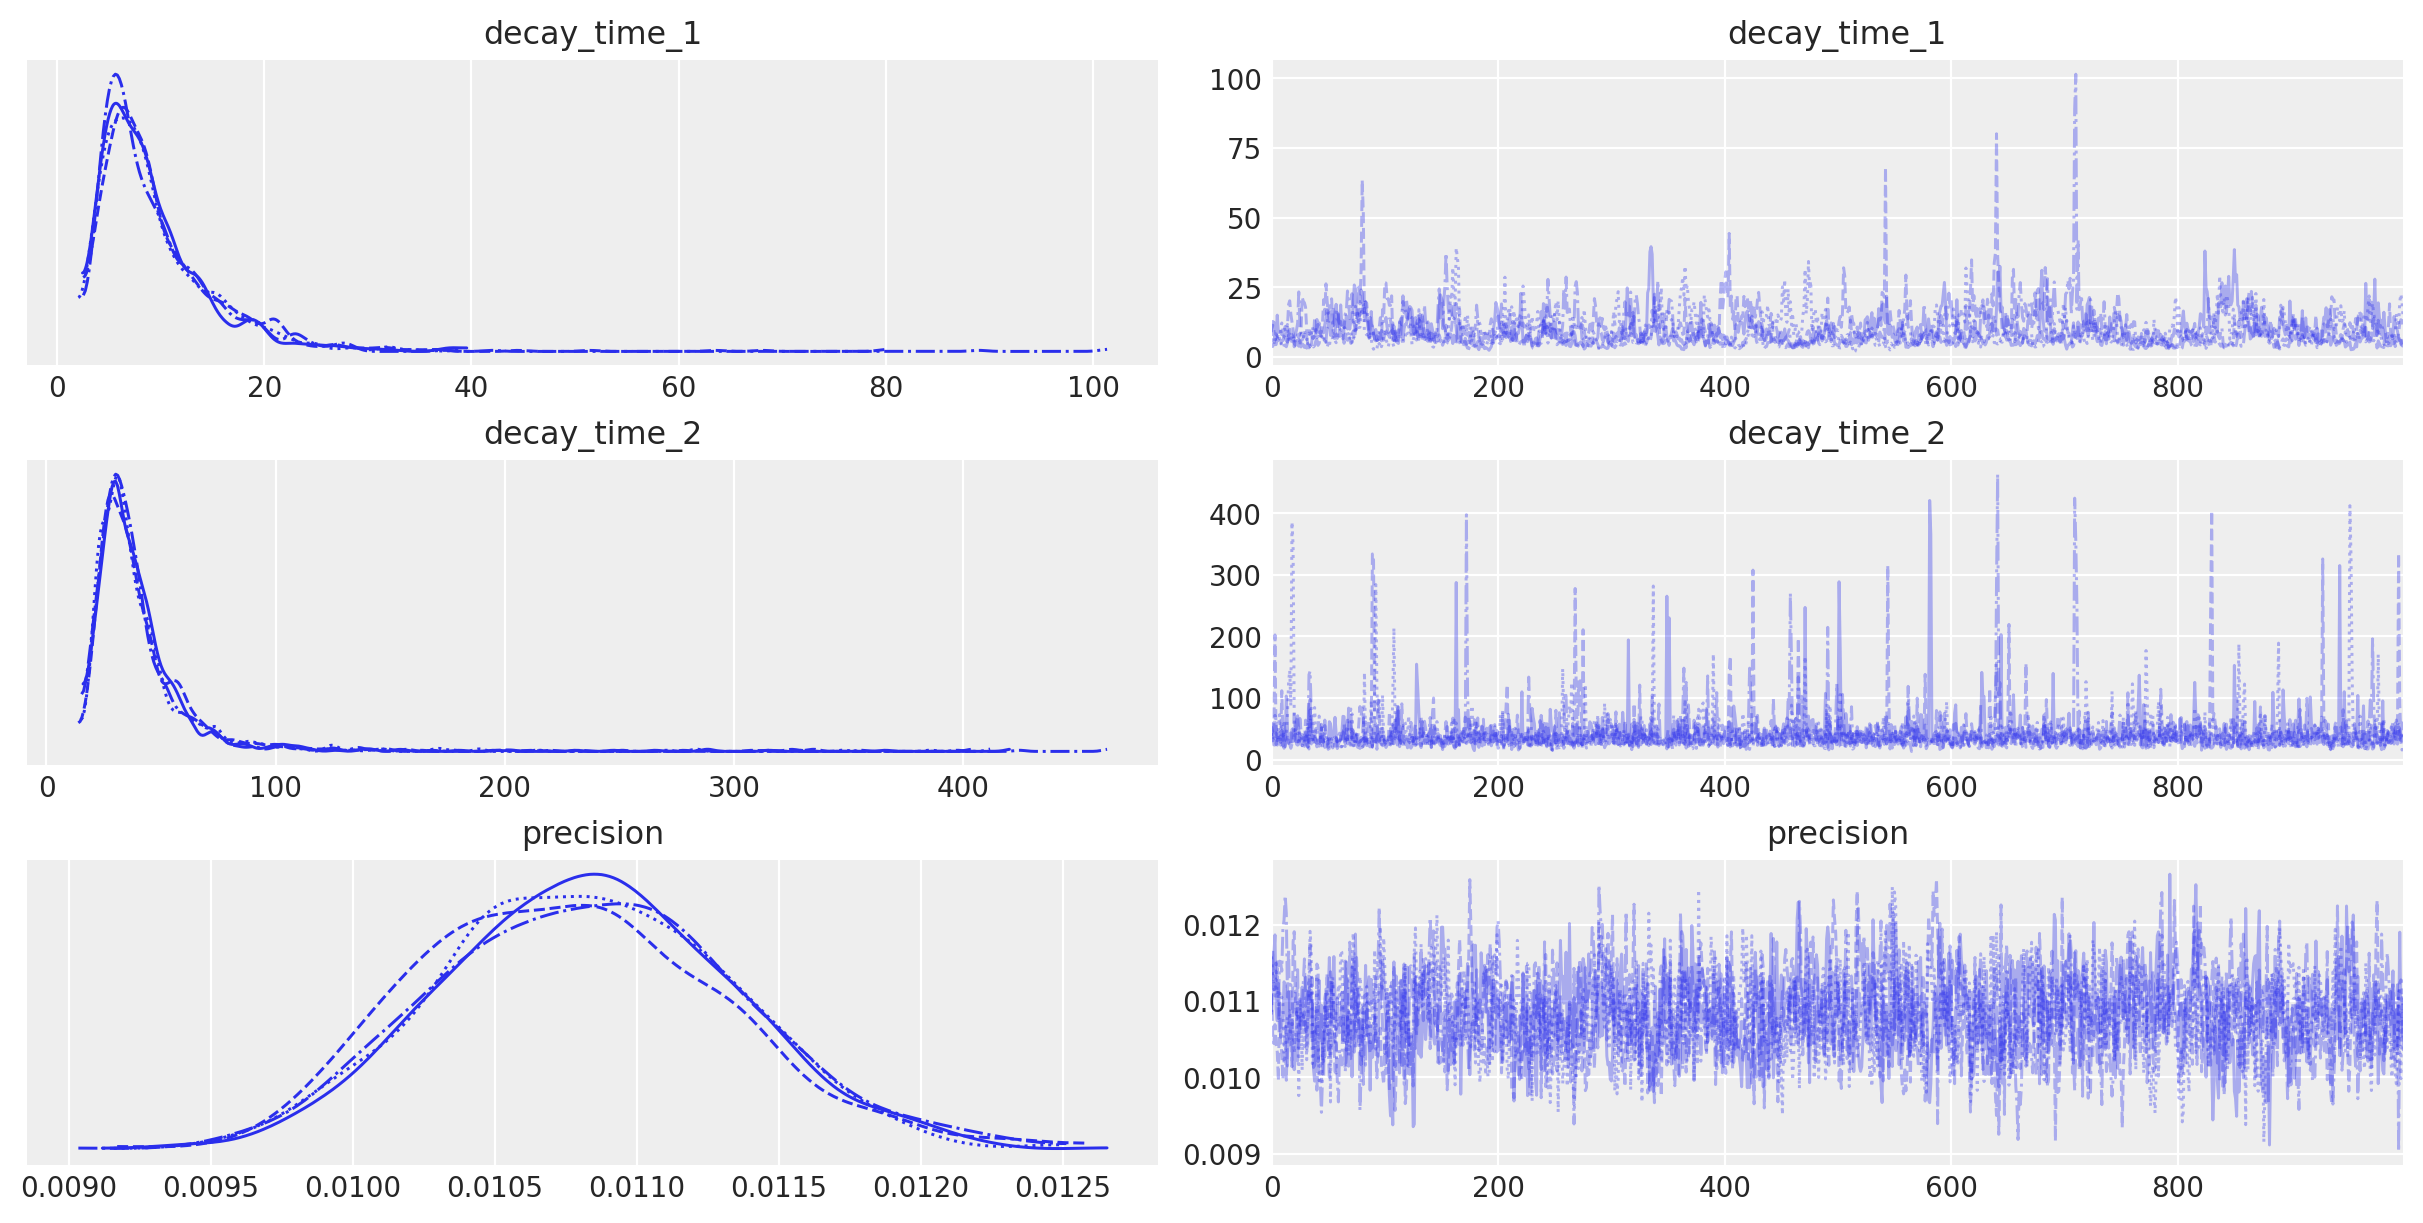

In [6]:
plot_trace(trace_multi_model_double, n_time_scale = 2)

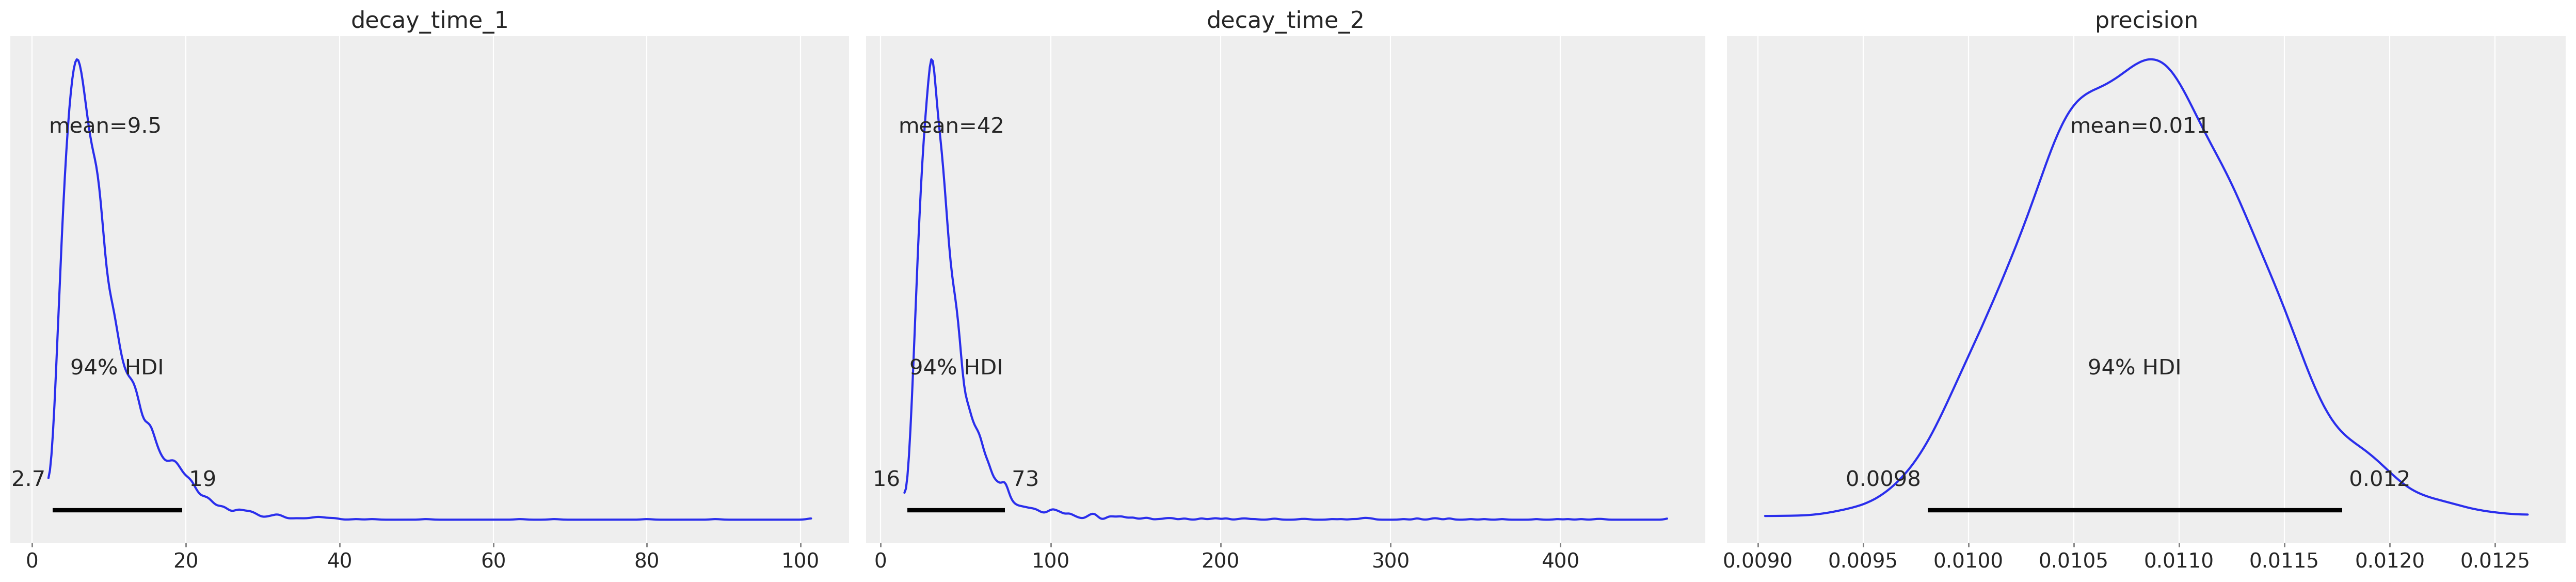

In [7]:
plot_posterior(trace_multi_model_double, n_time_scale = 2)

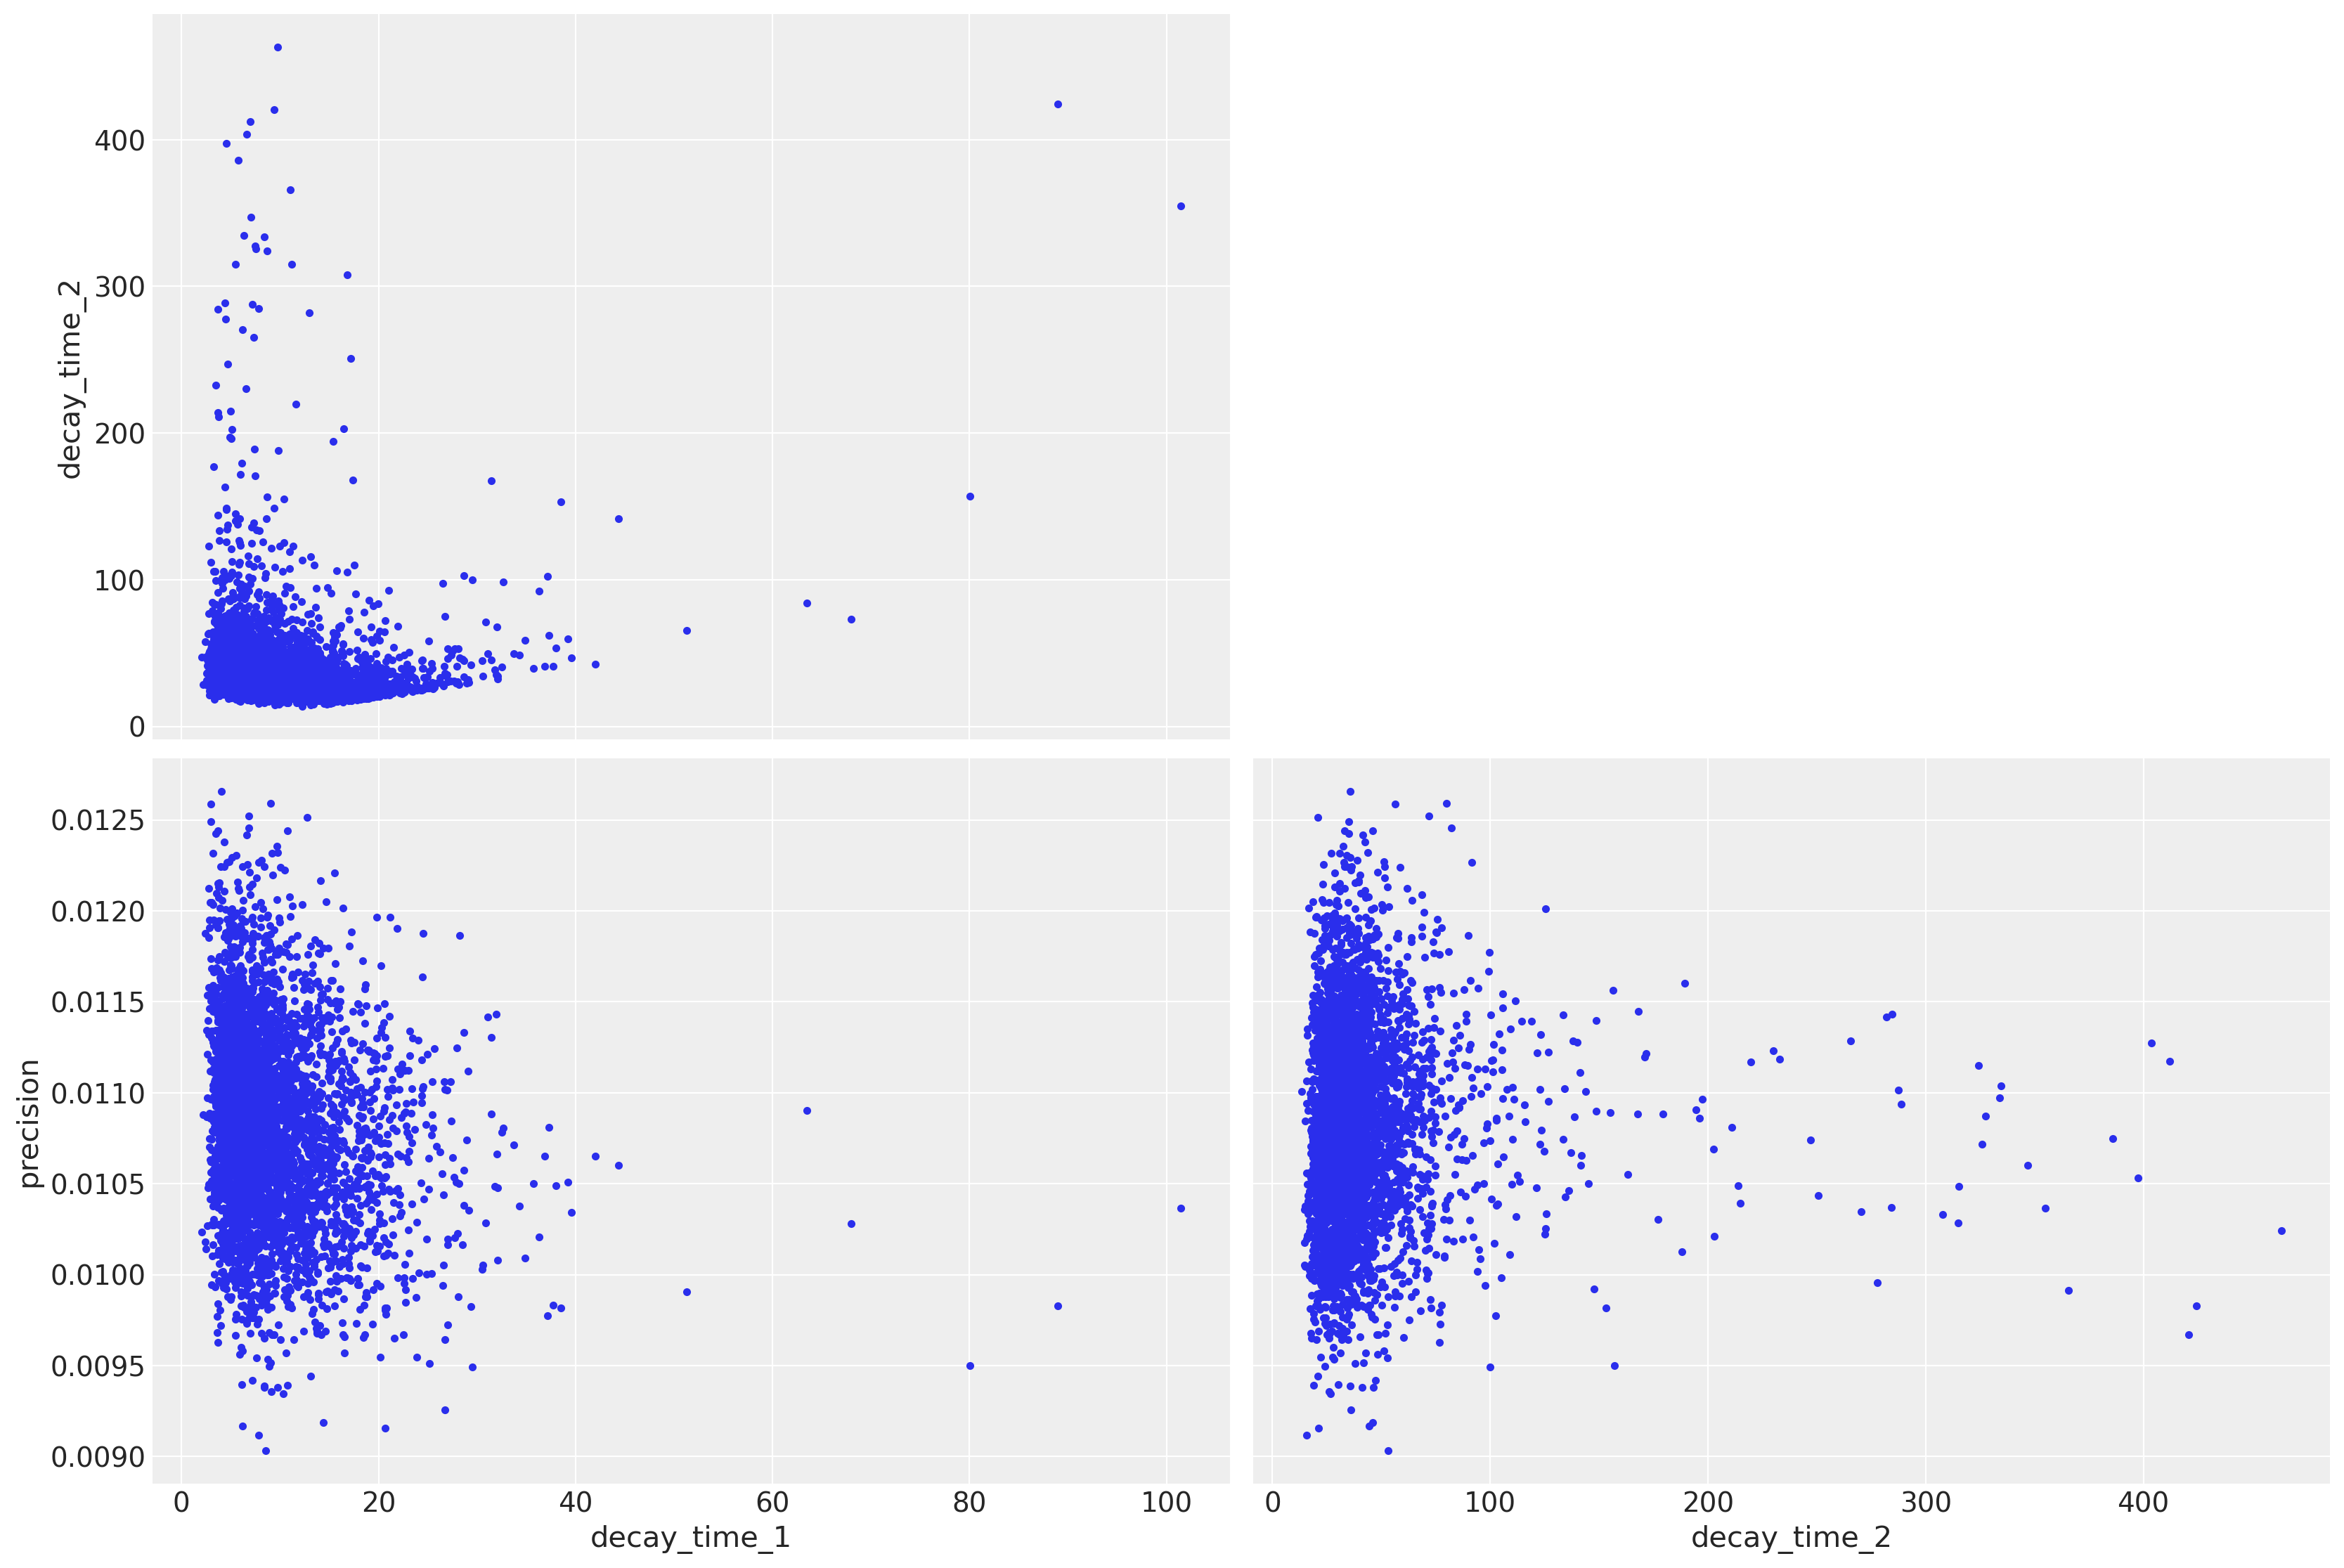

In [8]:
plot_pair(trace_multi_model_double, n_time_scale = 2)

### From the result of single AR(1) model, the 2 hour aged sample has a decay time constant less than 1 time frame. Indicating it as a liquid state, so we do not think the two time scale model fits this condition.

### Infer 7h aged data

In [14]:
ar1_multi_model_7h=set_single_precision_model(data_7h['Intensity'], quantization)
trace_multi_model_7h = run_model(ar1_multi_model_7h)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 86700
Interrupted at 86,699 [43%]: Average Loss = 4,695.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_2, y_1, precision, decay_time_split, decay_time_1]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 46 seconds.


In [ ]:
plot_trace(trace_multi_model_7h, n_time_scale = 2)

In [ ]:
plot_posterior(trace_multi_model_7h, n_time_scale = 2)

In [ ]:
plot_pair(trace_multi_model_7h, n_time_scale = 2)

### Infer 24 hour aged sample

In [ ]:
ar1_multi_model_24h=set_single_precision_model(data_24h['Intensity'], quantization)
trace_multi_model_24h = run_model(ar1_multi_model_24h)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 4,307.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_2, y_1, precision, decay_time_split, decay_time_1]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 44 seconds.


In [ ]:
plot_trace(trace_multi_model_24h, n_time_scale = 2)

In [ ]:
plot_posterior(trace_multi_model_24h, n_time_scale = 2)

In [ ]:
plot_pair(trace_multi_model_24h,n_time_scale = 2)